# Warming trend and marine heat waves of an Australian Marine Park

**What does this notebook do?** 
This notebook demonstrates how to generate and plot SST time-series for a Australian Marine Park, and to detect its warming trend and potential marine heat wave events.

**Requirements** 
You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set.

module use /g/data/v10/public/modules/modulefiles

module load dea

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository README for instructions on creating a Pull request).

**Date:** last updated 16th, Jan, 2019

**Author:** Zhi Huang

**Import modules**

In [1]:
from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
%matplotlib inline
import fiona
from shapely import geometry
from datacube.utils import geometry
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
from affine import Affine
from datacube.helpers import write_geotiff
import pandas as pd

**Specify a development database to connect to. It is on a different database server agdcstaging-db.nci.org.au, which means that your ~/.pgpass file will need to specify a password to connect to it as well.**

In [2]:
dc = Datacube(config='/g/data/u46/users/dsg547/modis_oc.conf')

**The only product in this database is the daily ocean colour data between 2002 and 2018.**

In [3]:
dc.list_products()

name              description  time   lat creation_time format  \
id                                                                          
5   modis_oc_1d  MODIS Ocean Cover Daily  None  None          None   None   

   label product_type instrument   lon platform        crs     resolution  \
id                                                                          
5   None  modis_oc_1d       None  None    MODIS  EPSG:4326  (-0.01, 0.01)   

   tile_size     spatial_dimensions  
id                                   
5       None  (latitude, longitude)

**Load full time-series of SST (Sea Surface Temperature), for the Lord Howe Marine Park area, from 2002 to 2018. It tooks 5 hours. Note that the resolution has been resampled from 0.01 dd to 0.1 dd to save memory usage.**

In [3]:
data = dc.load(product='modis_oc_1d', lat=(-27,-36), lon=(157,161), resolution=(-0.1, 0.1), measurements=(['sst']))

**Mask the nodata (-999) as 'nan'**

In [4]:
data = mask_invalid_data(data)

In [5]:
# note the time dimension: 5900
data

<xarray.Dataset>
Dimensions:    (latitude: 90, longitude: 40, time: 5900)
Coordinates:
  * time       (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2018-10-12T11:59:59.999999
  * latitude   (latitude) float64 -27.05 -27.15 -27.25 ... -35.75 -35.85 -35.95
  * longitude  (longitude) float64 157.1 157.2 157.2 157.4 ... 160.8 160.9 161.0
Data variables:
    sst        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    crs:      EPSG:4326

In [60]:
testDF = pd.DataFrame()
latlonDF = pd.DataFrame()
latList = []
lonList = []
idList = []
latIndex = 0
lonIndex = 0
id = 1
while latIndex < 90:
    while lonIndex < 40:
        lat = data.sst[:,latIndex,lonIndex].latitude.values
        lon = data.sst[:,latIndex,lonIndex].longitude.values
        latList.append(lat)
        lonList.append(lon)
        idList.append(id)
        sstData = data.sst[:,latIndex,lonIndex].values
        testDF[id] = sstData
        id += 1
        lonIndex += 1
    latIndex += 1
    lonIndex = 0
dateList = []
i = 0
while i < data.time.size:
    date = str(data.time[i].data)[:4] + str(data.time[i].data)[5:7] + str(data.time[i].data)[8:10]
    dateList.append(date)
    i += 1
testDF['date'] = dateList
testDF.set_index('date', inplace=True)
latlonDF['id'] = idList
latlonDF['lat'] = latList
latlonDF['lon'] = lonList


In [74]:
testDF.set_index('date', inplace=True)

In [82]:
import numpy as np
import scipy.ndimage as ndimage
def pad(data, maxPadLength=False):
    '''

    Linearly interpolate over missing data (NaNs) in a time series.

    Inputs:

      data	     Time series [1D numpy array]
      maxPadLength   Specifies the maximum length over which to interpolate,
                     i.e., any consecutive blocks of NaNs with length greater
                     than maxPadLength will be left as NaN. Set as an integer.
                     maxPadLength=False (default) interpolates over all NaNs.

    Written by Eric Oliver, Institue for Marine and Antarctic Studies, University of Tasmania, Jun 2015

    '''
    data_padded = data.copy()
    bad_indexes = np.isnan(data)
    good_indexes = np.logical_not(bad_indexes)
    good_data = data[good_indexes]
    interpolated = np.interp(bad_indexes.nonzero()[0], good_indexes.nonzero()[0], good_data)
    data_padded[bad_indexes] = interpolated
    if maxPadLength:
        blocks, n_blocks = ndimage.label(np.isnan(data))
        for bl in range(1, n_blocks+1):
            if (blocks==bl).sum() > maxPadLength:
                data_padded[blocks==bl] = np.nan

    return data_padded


18.819900512695312

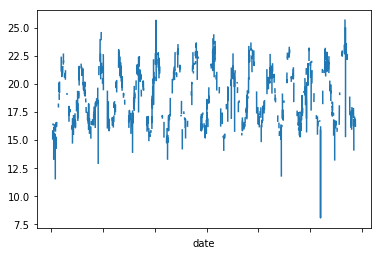

In [84]:
testDF[3600].plot()
testDF[3600].mean()

18.774232864379883

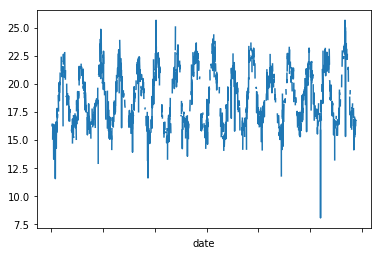

In [85]:
sst_3600 = testDF[3600]
sst_3600_i = pad(sst_3600,maxPadLength=2)
sst_3600_i.plot()
sst_3600_i.mean()

In [88]:
from datetime import datetime
date = testDF.index[1]
dayofyear =datetime.strptime(date,'%Y%m%d').timetuple().tm_yday

In [89]:
dayofyear

186

In [66]:
latlonDF.head(1)

id     lat     lon
0   1  -27.05  157.05

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
LH_path = '/home/547/zxh547/dea-notebooks/shapefiles/LH_AMP.shp'
i = 0
propertiesList = []
dayofyears = []
dates = []
years = []
while i < data['sst'].time.size:
    date = str(data['sst'].time[i].data)[:10]
    year = str(data['sst'].time[i].data)[:4]
    ## remove the four Feb 29 in the leap years from the collection
    if date == '2004-02-29':
        i = i + 1
    elif date == '2008-02-29':
        i = i + 1
    elif date == '2012-02-29':
        i = i + 1
    elif date == '2016-02-29':
        i = i + 1
    else:
        ## calculate dayofyear
        ## because the 4 Feb-29 dates have been removed, the dayofyears for all years are now matched
        dayofyear = datetime.strptime(date,'%Y-%m-%d').timetuple().tm_yday
        if (year == '2004') & (dayofyear > 60):
            dayofyear = dayofyear - 1
        if (year == '2008') & (dayofyear > 60):
            dayofyear = dayofyear - 1
        if (year == '2012') & (dayofyear > 60):
            dayofyear = dayofyear - 1
        if (year == '2016') & (dayofyear > 60):
            dayofyear = dayofyear - 1
        print(date)
        print(dayofyear)
        sst = data.sst[i].data
        stats = zonal_stats(LH_path,sst,affine=data.affine,stats=['mean'],geojson_out=True)

        propertiesList.append(stats[0]['properties'])
        dayofyears.append(dayofyear)
        dates.append(date)
        years.append(year)
        i = i + 1
df = pd.DataFrame(propertiesList)
df['date']=dates
df['dayofyear']=dayofyears
df['year']=years
df.set_index('date',inplace=True)


In [59]:
data.sst[:,0,0].latitude.values

array(-27.05)

**plot the SST of the second day (2002-07-05)**

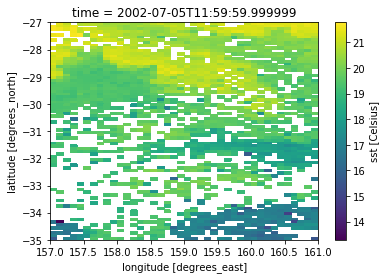

In [7]:
# plot the second day
data.sst[1].plot()

**Try merging the data together every 5 days to fill in the gaps caused by clouds**

In [6]:
data2 = data.resample(time='5D').mean()

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [7]:
# note the time dimension after merging: 1189
data2

<xarray.Dataset>
Dimensions:    (latitude: 90, longitude: 40, time: 1189)
Coordinates:
  * time       (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2018-10-08T11:59:59.999999
  * latitude   (latitude) float64 -27.05 -27.15 -27.25 ... -35.75 -35.85 -35.95
  * longitude  (longitude) float64 157.1 157.2 157.2 157.4 ... 160.8 160.9 161.0
Data variables:
    sst        (time, latitude, longitude) float32 21.655 21.5 ... nan nan

**load the Lord Howe Marine Park vector data**

In [8]:
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/LH_AMP.shp'

#open the polygon
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)


#plot polygon to check it looks ok
plt.clf()
shape_plot = gpd.read_file(poly_path)
shape_plot.plot()

plt.show()


In [11]:
## assign crs attribute for data2
data2.attrs['crs']=data.crs

In [12]:
data2.affine

Affine(0.10000000000000014, 0.0, 157.0,
       0.0, -0.10000000000000002, -27.0)

## conduct zonal statstists

In [13]:
stats = zonal_stats(poly_path,data2.sst[0].data,affine=data2.affine)

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


In [14]:
stats

[{'min': 14.71500015258789,
  'max': 21.395000457763672,
  'mean': 19.234676286784918,
  'count': 937}]

In [15]:
stats1 = zonal_stats(poly_path,data.sst[1].data,affine=data.affine,stats=['min','max','mean','range','median','std','sum','count'],geojson_out=True)

In [16]:
stats1[0]['properties']

OrderedDict([('MPA_NAME', 'Lord Howe'),
             ('network', 'Temperate East'),
             ('area', 110138.572172),
             ('min', 15.9399995803833),
             ('max', 21.25),
             ('mean', 19.18923144963942),
             ('count', 566),
             ('sum', 10861.10500049591),
             ('std', 1.1430294640417835),
             ('median', 19.450000762939453),
             ('range', 5.310000419616699)])

## list results as table

In [17]:
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
propertiesList = []
for f in stats1:
    propertiesList.append(f['properties'])
df = pd.DataFrame(propertiesList)

In [18]:
df

MPA_NAME         network           area    min    max       mean  count  \
0  Lord Howe  Temperate East  110138.572172  15.94  21.25  19.189231    566   

         sum       std     median  range  
0  10861.105  1.143029  19.450001   5.31

**conduct zonal statistics for all 1189 SST data (data2), convert the results to a DataFrame**

**in doing so, we obtained the SST time-series of the Lord Howe Marine Park**

In [19]:
import pandas as pd
import numpy as np
LH_path = '/home/547/zxh547/dea-notebooks/shapefiles/LH_AMP.shp'
i = 0
propertiesList = []
while i < data2['sst'].time.size:
    time = str(data2['sst'].time[i].data)[:10]
    print(time)
    sst = data2.sst[i].data
    stats = zonal_stats(LH_path,sst,affine=data.affine,stats=['min','max','mean','range','median','std','sum','count'],geojson_out=True)
    
    propertiesList.append(stats[0]['properties'])
    
    
    i = i + 1
df = pd.DataFrame(propertiesList)
times = np.datetime_as_string(data2['time'].data)
df['time']=times
df.set_index('time',inplace=True)

2002-07-04
2002-07-09
2002-07-14
2002-07-19
2002-07-24
2002-07-29
2002-08-03
2002-08-08
2002-08-13
2002-08-18
2002-08-23
2002-08-28
2002-09-02
2002-09-07
2002-09-12
2002-09-17
2002-09-22
2002-09-27
2002-10-02
2002-10-07
2002-10-12
2002-10-17
2002-10-22
2002-10-27
2002-11-01
2002-11-06
2002-11-11
2002-11-16
2002-11-21
2002-11-26
2002-12-01
2002-12-06
2002-12-11
2002-12-16
2002-12-21
2002-12-26
2002-12-31
2003-01-05
2003-01-10
2003-01-15
2003-01-20
2003-01-25
2003-01-30
2003-02-04
2003-02-09
2003-02-14
2003-02-19
2003-02-24
2003-03-01
2003-03-06
2003-03-11
2003-03-16
2003-03-21
2003-03-26
2003-03-31
2003-04-05
2003-04-10
2003-04-15
2003-04-20
2003-04-25
2003-04-30
2003-05-05
2003-05-10
2003-05-15
2003-05-20
2003-05-25
2003-05-30
2003-06-04
2003-06-09
2003-06-14
2003-06-19
2003-06-24
2003-06-29
2003-07-04
2003-07-09
2003-07-14
2003-07-19
2003-07-24
2003-07-29
2003-08-03
2003-08-08
2003-08-13
2003-08-18
2003-08-23
2003-08-28
2003-09-02
2003-09-07
2003-09-12
2003-09-17
2003-09-22
2003-09-27

2012-11-08
2012-11-13
2012-11-18
2012-11-23
2012-11-28
2012-12-03
2012-12-08
2012-12-13
2012-12-18
2012-12-23
2012-12-28
2013-01-02
2013-01-07
2013-01-12
2013-01-17
2013-01-22
2013-01-27
2013-02-01
2013-02-06
2013-02-11
2013-02-16
2013-02-21
2013-02-26
2013-03-03
2013-03-08
2013-03-13
2013-03-18
2013-03-23
2013-03-28
2013-04-02
2013-04-07
2013-04-12
2013-04-17
2013-04-22
2013-04-27
2013-05-02
2013-05-07
2013-05-12
2013-05-17
2013-05-22
2013-05-27
2013-06-01
2013-06-06
2013-06-11
2013-06-16
2013-06-21
2013-06-26
2013-07-01
2013-07-06
2013-07-11
2013-07-16
2013-07-21
2013-07-26
2013-07-31
2013-08-05
2013-08-10
2013-08-15
2013-08-20
2013-08-25
2013-08-30
2013-09-04
2013-09-09
2013-09-14
2013-09-19
2013-09-24
2013-09-29
2013-10-04
2013-10-09
2013-10-14
2013-10-19
2013-10-24
2013-10-29
2013-11-03
2013-11-08
2013-11-13
2013-11-18
2013-11-23
2013-11-28
2013-12-03
2013-12-08
2013-12-13
2013-12-18
2013-12-23
2013-12-28
2014-01-02
2014-01-07
2014-01-12
2014-01-17
2014-01-22
2014-01-27
2014-02-01

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1189 entries, 2002-07-04T11:59:59.999999000 to 2018-10-08T11:59:59.999999000
Data columns (total 11 columns):
MPA_NAME    1189 non-null object
network     1189 non-null object
area        1189 non-null float64
min         1183 non-null float64
max         1183 non-null float64
mean        1183 non-null float64
count       1189 non-null int64
sum         1183 non-null float64
std         1183 non-null float64
median      1183 non-null float64
range       1183 non-null float64
dtypes: float64(8), int64(1), object(2)
memory usage: 111.5+ KB


**plot the mean SST time series for the Lord Howe Marine Park**

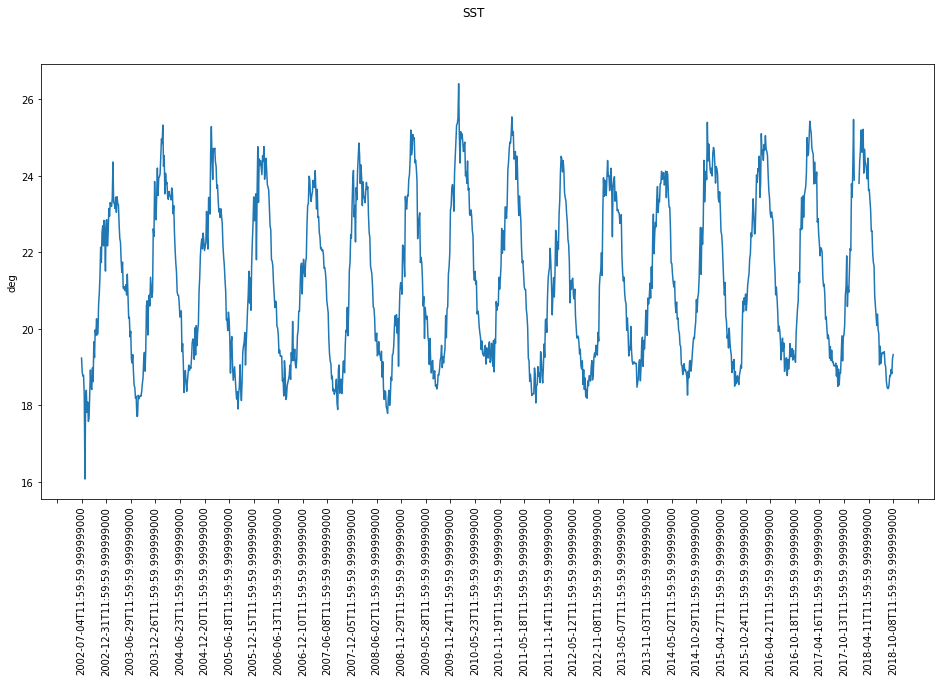

In [21]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

ax.plot(df.index,df['mean'])
ax.xaxis.set_major_locator(ticker.MultipleLocator(36))
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

**fit a linear trend line to the time-series and plot it**

                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.525
Date:                Mon, 25 Feb 2019   Prob (F-statistic):             0.0607
Time:                        16:10:22   Log-Likelihood:                -2556.7
No. Observations:                1183   AIC:                             5117.
Df Residuals:                    1181   BIC:                             5127.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.0791      0.122    172.423      0.0

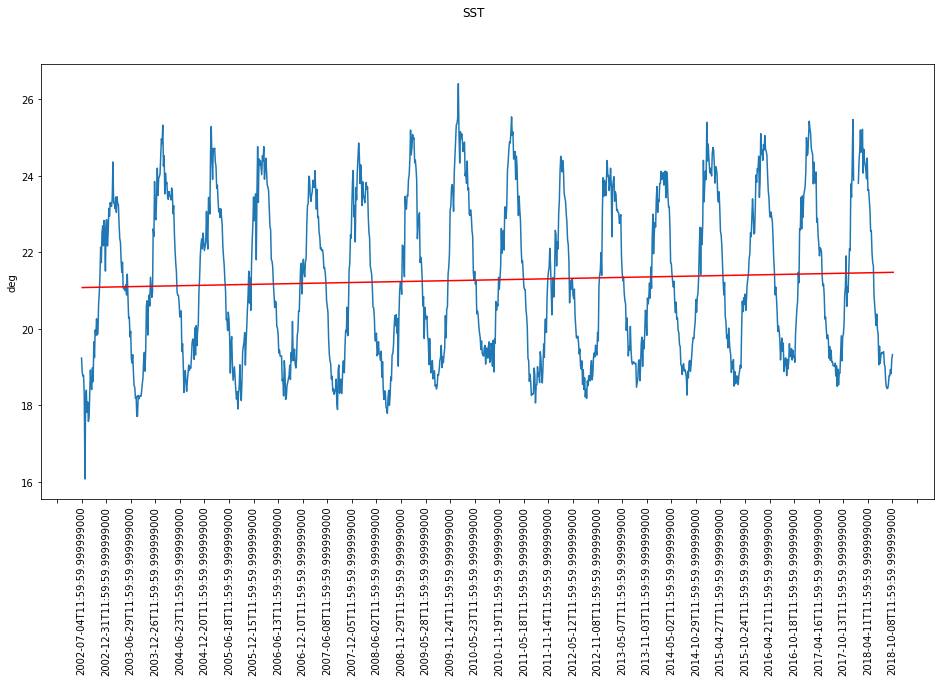

In [22]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,df['mean'].size+1,1)
df['ind'] = ind
dates = np.datetime_as_string(data2['time'].data)
df['date'] = dates
fit = sm.ols(formula='mean ~ ind', data=df).fit()
print(fit.summary())

predict = fit.predict(df)
df['fitted'] = predict

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

ax.plot(df.date,df['mean'])

ax.xaxis.set_major_locator(ticker.MultipleLocator(36))
ax.plot(df.ind, df.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

**calculate the warming rate (per 5-D, in this case)**

In [23]:
(df['fitted'].max() - df['fitted'].min()) / df['fitted'].size

0.00033532504377904677

**calculate the warming (deg) in the entire time-series**

In [24]:
# how much warming during last 16 years
df['fitted'].max() - df['fitted'].min()

0.3987014770532866

In [14]:
data

<xarray.Dataset>
Dimensions:    (latitude: 80, longitude: 40, time: 5900)
Coordinates:
  * time       (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2018-10-12T11:59:59.999999
  * latitude   (latitude) float64 -27.05 -27.15 -27.25 ... -34.75 -34.85 -34.95
  * longitude  (longitude) float64 157.1 157.2 157.2 157.4 ... 160.8 160.9 161.0
Data variables:
    sst        (time, latitude, longitude) float32 nan nan nan ... 16.825 nan
Attributes:
    crs:      EPSG:4326

**conduct zonal statistics for all 5900 SST data (data), convert the results to a DataFrame**

**in doing so, we obtained the SST time-series of the Lord Howe Marine Park**

In [25]:
import pandas as pd
import numpy as np
from datetime import datetime
LH_path = '/home/547/zxh547/dea-notebooks/shapefiles/LH_AMP.shp'
i = 0
propertiesList = []
dayofyears = []
dates = []
years = []
while i < data['sst'].time.size:
    date = str(data['sst'].time[i].data)[:10]
    year = str(data['sst'].time[i].data)[:4]
    ## remove the four Feb 29 in the leap years from the collection
    if date == '2004-02-29':
        i = i + 1
    elif date == '2008-02-29':
        i = i + 1
    elif date == '2012-02-29':
        i = i + 1
    elif date == '2016-02-29':
        i = i + 1
    else:
        ## calculate dayofyear
        ## because the 4 Feb-29 dates have been removed, the dayofyears for all years are now matched
        dayofyear = datetime.strptime(date,'%Y-%m-%d').timetuple().tm_yday
        if (year == '2004') & (dayofyear > 60):
            dayofyear = dayofyear - 1
        if (year == '2008') & (dayofyear > 60):
            dayofyear = dayofyear - 1
        if (year == '2012') & (dayofyear > 60):
            dayofyear = dayofyear - 1
        if (year == '2016') & (dayofyear > 60):
            dayofyear = dayofyear - 1
        print(date)
        print(dayofyear)
        sst = data.sst[i].data
        stats = zonal_stats(LH_path,sst,affine=data.affine,stats=['mean'],geojson_out=True)

        propertiesList.append(stats[0]['properties'])
        dayofyears.append(dayofyear)
        dates.append(date)
        years.append(year)
        i = i + 1
df = pd.DataFrame(propertiesList)
df['date']=dates
df['dayofyear']=dayofyears
df['year']=years
df.set_index('date',inplace=True)

2002-07-04
185
2002-07-05
186
2002-07-06
187
2002-07-07
188
2002-07-08
189
2002-07-09
190
2002-07-10
191
2002-07-11
192
2002-07-12
193
2002-07-13
194
2002-07-14
195
2002-07-15
196
2002-07-16
197
2002-07-17
198
2002-07-18
199
2002-07-19
200
2002-07-20
201


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: 

2002-07-21
202
2002-07-22
203
2002-07-23
204
2002-07-24
205
2002-07-25
206
2002-07-26
207
2002-07-27
208
2002-07-28
209
2002-07-29
210
2002-08-07
219
2002-08-08
220
2002-08-09
221
2002-08-10
222
2002-08-11
223
2002-08-12
224
2002-08-13
225
2002-08-14
226
2002-08-15
227
2002-08-16
228
2002-08-17
229
2002-08-18
230


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2002-08-19
231
2002-08-20
232
2002-08-21
233
2002-08-22
234
2002-08-23
235
2002-08-24
236
2002-08-25
237
2002-08-26
238
2002-08-27
239
2002-08-28
240
2002-08-29
241
2002-08-30
242
2002-08-31
243
2002-09-01
244
2002-09-02
245
2002-09-03
246
2002-09-04
247
2002-09-05
248
2002-09-06
249
2002-09-07
250
2002-09-08
251
2002-09-09
252


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2002-09-10
253
2002-09-11
254
2002-09-12
255
2002-09-13
256
2002-09-14
257
2002-09-15
258
2002-09-16
259
2002-09-17
260
2002-09-18
261
2002-09-19
262
2002-09-20
263
2002-09-21
264
2002-09-22
265
2002-09-23
266
2002-09-24
267
2002-09-25
268
2002-09-26
269
2002-09-27
270
2002-09-28
271
2002-09-29
272
2002-09-30
273
2002-10-01
274


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2002-10-02
275
2002-10-03
276
2002-10-04
277
2002-10-05
278
2002-10-06
279
2002-10-07
280
2002-10-08
281
2002-10-09
282
2002-10-10
283
2002-10-11
284
2002-10-12
285
2002-10-13
286
2002-10-14
287
2002-10-15
288
2002-10-16
289
2002-10-17
290
2002-10-18
291
2002-10-19
292
2002-10-20
293
2002-10-21
294


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2002-10-22
295
2002-10-23
296
2002-10-24
297
2002-10-25
298
2002-10-26
299
2002-10-27
300
2002-10-28
301
2002-10-29
302
2002-10-30
303
2002-10-31
304
2002-11-01
305
2002-11-02
306
2002-11-03
307
2002-11-04
308
2002-11-05
309
2002-11-06
310
2002-11-07
311
2002-11-08
312
2002-11-09
313


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2002-11-10
314
2002-11-11
315
2002-11-12
316
2002-11-13
317
2002-11-14
318
2002-11-15
319
2002-11-16
320
2002-11-17
321
2002-11-18
322
2002-11-19
323
2002-11-20
324
2002-11-21
325
2002-11-22
326
2002-11-23
327
2002-11-24
328
2002-11-25
329
2002-11-26
330
2002-11-27
331
2002-11-28
332
2002-11-29
333


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2002-11-30
334
2002-12-01
335
2002-12-02
336
2002-12-03
337
2002-12-04
338
2002-12-05
339
2002-12-06
340
2002-12-07
341
2002-12-08
342
2002-12-09
343
2002-12-10
344
2002-12-11
345
2002-12-12
346
2002-12-13
347
2002-12-14
348
2002-12-15
349
2002-12-16
350
2002-12-17
351
2002-12-18
352
2002-12-19
353


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2002-12-20
354
2002-12-21
355
2002-12-22
356
2002-12-23
357
2002-12-24
358
2002-12-25
359
2002-12-26
360
2002-12-27
361
2002-12-28
362
2002-12-29
363
2002-12-30
364
2002-12-31
365
2003-01-01
1
2003-01-02
2
2003-01-03
3
2003-01-04
4
2003-01-05
5
2003-01-06
6
2003-01-07
7
2003-01-08
8


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2003-01-09
9
2003-01-10
10
2003-01-11
11
2003-01-12
12
2003-01-13
13
2003-01-14
14
2003-01-15
15
2003-01-16
16
2003-01-17
17
2003-01-18
18
2003-01-19
19
2003-01-20
20
2003-01-21
21
2003-01-22
22
2003-01-23
23
2003-01-24
24
2003-01-25
25
2003-01-26
26
2003-01-27
27
2003-01-28
28
2003-01-29
29
2003-01-30
30


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2003-01-31
31
2003-02-01
32
2003-02-02
33
2003-02-03
34
2003-02-04
35
2003-02-05
36
2003-02-06
37
2003-02-07
38
2003-02-08
39
2003-02-09
40
2003-02-10
41
2003-02-11
42
2003-02-12
43
2003-02-13
44
2003-02-14
45
2003-02-15
46
2003-02-16
47
2003-02-17
48
2003-02-18
49
2003-02-19
50


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2003-02-20
51
2003-02-21
52
2003-02-22
53
2003-02-23
54
2003-02-24
55
2003-02-25
56
2003-02-26
57
2003-02-27
58
2003-02-28
59
2003-03-01
60
2003-03-02
61
2003-03-03
62
2003-03-04
63
2003-03-05
64
2003-03-06
65
2003-03-07
66
2003-03-08
67
2003-03-09
68
2003-03-10
69
2003-03-11
70


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2003-03-12
71
2003-03-13
72
2003-03-14
73
2003-03-15
74
2003-03-16
75
2003-03-17
76
2003-03-18
77
2003-03-19
78
2003-03-20
79
2003-03-21
80
2003-03-22
81
2003-03-23
82
2003-03-24
83
2003-03-25
84
2003-03-26
85
2003-03-27
86
2003-03-28
87
2003-03-29
88
2003-03-30
89
2003-03-31
90
2003-04-01
91
2003-04-02
92


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2003-04-03
93
2003-04-04
94
2003-04-05
95
2003-04-06
96
2003-04-07
97
2003-04-08
98
2003-04-09
99
2003-04-10
100
2003-04-11
101
2003-04-12
102
2003-04-13
103
2003-04-14
104
2003-04-15
105
2003-04-16
106
2003-04-17
107
2003-04-18
108
2003-04-19
109
2003-04-20
110
2003-04-21
111


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2003-04-22
112
2003-04-23
113
2003-04-24
114
2003-04-25
115
2003-04-26
116
2003-04-27
117
2003-04-28
118
2003-04-29
119
2003-04-30
120
2003-05-01
121
2003-05-02
122
2003-05-03
123
2003-05-04
124
2003-05-05
125
2003-05-06
126
2003-05-07
127
2003-05-08
128
2003-05-09
129
2003-05-10
130
2003-05-11
131


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2003-05-12
132
2003-05-13
133
2003-05-14
134
2003-05-15
135
2003-05-16
136
2003-05-17
137
2003-05-18
138
2003-05-19
139
2003-05-20
140
2003-05-21
141
2003-05-22
142
2003-05-23
143
2003-05-24
144
2003-05-25
145
2003-05-26
146
2003-05-27
147
2003-05-28
148
2003-05-29
149
2003-05-30
150
2003-05-31
151
2003-06-01
152
2003-06-02
153


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2003-06-03
154
2003-06-04
155
2003-06-05
156
2003-06-06
157
2003-06-07
158
2003-06-08
159
2003-06-09
160
2003-06-10
161
2003-06-11
162
2003-06-12
163
2003-06-13
164
2003-06-14
165
2003-06-15
166
2003-06-16
167
2003-06-17
168
2003-06-18
169
2003-06-19
170
2003-06-20
171
2003-06-21
172
2003-06-22
173
2003-06-23
174
2003-06-24
175
2003-06-25
176
2003-06-26
177
2003-06-27
178


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2003-06-28
179
2003-06-29
180
2003-06-30
181
2003-07-01
182
2003-07-02
183
2003-07-03
184
2003-07-04
185
2003-07-05
186
2003-07-06
187
2003-07-07
188
2003-07-08
189
2003-07-09
190
2003-07-10
191
2003-07-11
192
2003-07-12
193
2003-07-13
194
2003-07-14
195
2003-07-15
196
2003-07-16
197
2003-07-17
198


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2003-07-18
199
2003-07-19
200
2003-07-20
201
2003-07-21
202
2003-07-22
203
2003-07-23
204
2003-07-24
205
2003-07-25
206
2003-07-26
207
2003-07-27
208
2003-07-28
209
2003-07-29
210
2003-07-30
211
2003-07-31
212
2003-08-01
213
2003-08-02
214
2003-08-03
215
2003-08-04
216
2003-08-05
217


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2003-08-06
218
2003-08-07
219
2003-08-08
220
2003-08-09
221
2003-08-10
222
2003-08-11
223
2003-08-12
224
2003-08-13
225
2003-08-14
226
2003-08-15
227
2003-08-16
228
2003-08-17
229
2003-08-18
230
2003-08-19
231
2003-08-20
232
2003-08-21
233
2003-08-22
234
2003-08-23
235
2003-08-24
236
2003-08-25
237


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2003-08-26
238
2003-08-27
239
2003-08-28
240
2003-08-29
241
2003-08-30
242
2003-08-31
243
2003-09-01
244
2003-09-02
245
2003-09-03
246
2003-09-04
247
2003-09-05
248
2003-09-06
249
2003-09-07
250
2003-09-08
251
2003-09-09
252
2003-09-10
253
2003-09-11
254
2003-09-12
255
2003-09-13
256
2003-09-14
257


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2003-09-15
258
2003-09-16
259
2003-09-17
260
2003-09-18
261
2003-09-19
262
2003-09-20
263
2003-09-21
264
2003-09-22
265
2003-09-23
266
2003-09-24
267
2003-09-25
268
2003-09-26
269
2003-09-27
270
2003-09-28
271
2003-09-29
272
2003-09-30
273
2003-10-01
274
2003-10-02
275
2003-10-03
276
2003-10-04
277
2003-10-05
278


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2003-10-06
279
2003-10-07
280
2003-10-08
281
2003-10-09
282
2003-10-10
283
2003-10-11
284
2003-10-12
285
2003-10-13
286
2003-10-14
287
2003-10-15
288
2003-10-16
289
2003-10-17
290
2003-10-18
291
2003-10-19
292
2003-10-20
293
2003-10-21
294
2003-10-22
295
2003-10-23
296
2003-10-24
297
2003-10-25
298
2003-10-26
299


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2003-10-27
300
2003-10-28
301
2003-10-29
302
2003-10-30
303
2003-10-31
304
2003-11-01
305
2003-11-02
306
2003-11-03
307
2003-11-04
308
2003-11-05
309
2003-11-06
310
2003-11-07
311
2003-11-08
312
2003-11-09
313
2003-11-10
314
2003-11-11
315
2003-11-12
316
2003-11-13
317
2003-11-14
318
2003-11-15
319
2003-11-16
320


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2003-11-17
321
2003-11-18
322
2003-11-19
323
2003-11-20
324
2003-11-21
325
2003-11-22
326
2003-11-23
327
2003-11-24
328
2003-11-25
329
2003-11-26
330
2003-11-27
331
2003-11-28
332
2003-11-29
333
2003-11-30
334
2003-12-01
335
2003-12-02
336
2003-12-03
337
2003-12-04
338
2003-12-05
339
2003-12-06
340
2003-12-07
341


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2003-12-08
342
2003-12-09
343
2003-12-10
344
2003-12-11
345
2003-12-12
346
2003-12-13
347
2003-12-14
348
2003-12-15
349
2003-12-16
350
2003-12-17
351
2003-12-18
352
2003-12-19
353
2003-12-20
354
2003-12-21
355
2003-12-22
356
2003-12-23
357
2003-12-24
358
2003-12-25
359
2003-12-26
360
2003-12-27
361
2003-12-28
362
2003-12-29
363


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2003-12-30
364
2003-12-31
365
2004-01-01
1
2004-01-02
2
2004-01-03
3
2004-01-04
4
2004-01-05
5
2004-01-06
6
2004-01-07
7
2004-01-08
8
2004-01-09
9
2004-01-10
10
2004-01-11
11
2004-01-12
12
2004-01-13
13
2004-01-14
14
2004-01-15
15
2004-01-16
16
2004-01-17
17
2004-01-18
18


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2004-01-19
19
2004-01-20
20
2004-01-21
21
2004-01-22
22
2004-01-23
23
2004-01-24
24
2004-01-25
25
2004-01-26
26
2004-01-27
27
2004-01-28
28
2004-01-29
29
2004-01-30
30
2004-01-31
31
2004-02-01
32
2004-02-02
33
2004-02-03
34
2004-02-04
35
2004-02-05
36
2004-02-06
37


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2004-02-07
38
2004-02-08
39
2004-02-09
40
2004-02-10
41
2004-02-11
42
2004-02-12
43
2004-02-13
44
2004-02-14
45
2004-02-15
46
2004-02-16
47
2004-02-17
48
2004-02-18
49
2004-02-19
50
2004-02-20
51
2004-02-21
52
2004-02-22
53
2004-02-23
54
2004-02-24
55
2004-02-25
56
2004-02-26
57


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2004-02-27
58
2004-02-28
59
2004-03-01
60
2004-03-02
61
2004-03-03
62
2004-03-04
63
2004-03-05
64
2004-03-06
65
2004-03-07
66
2004-03-08
67
2004-03-09
68
2004-03-10
69
2004-03-11
70
2004-03-12
71
2004-03-13
72
2004-03-14
73
2004-03-15
74
2004-03-16
75
2004-03-17
76
2004-03-18
77


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2004-03-19
78
2004-03-20
79
2004-03-21
80
2004-03-22
81
2004-03-23
82
2004-03-24
83
2004-03-25
84
2004-03-26
85
2004-03-27
86
2004-03-28
87
2004-03-29
88
2004-03-30
89
2004-03-31
90
2004-04-01
91
2004-04-02
92
2004-04-03
93
2004-04-04
94
2004-04-05
95
2004-04-06
96
2004-04-07
97


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2004-04-08
98
2004-04-09
99
2004-04-10
100
2004-04-11
101
2004-04-12
102
2004-04-13
103
2004-04-14
104
2004-04-15
105
2004-04-16
106
2004-04-17
107
2004-04-18
108
2004-04-19
109
2004-04-20
110
2004-04-21
111
2004-04-22
112
2004-04-23
113
2004-04-24
114
2004-04-25
115
2004-04-26
116


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2004-04-27
117
2004-04-28
118
2004-04-29
119
2004-04-30
120
2004-05-01
121
2004-05-02
122
2004-05-03
123
2004-05-04
124
2004-05-05
125
2004-05-06
126
2004-05-07
127
2004-05-08
128
2004-05-09
129
2004-05-10
130
2004-05-11
131
2004-05-12
132
2004-05-13
133
2004-05-14
134
2004-05-15
135
2004-05-16
136
2004-05-17
137


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2004-05-18
138
2004-05-19
139
2004-05-20
140
2004-05-21
141
2004-05-22
142
2004-05-23
143
2004-05-24
144
2004-05-25
145
2004-05-26
146
2004-05-27
147
2004-05-28
148
2004-05-29
149
2004-05-30
150
2004-05-31
151
2004-06-01
152
2004-06-02
153
2004-06-03
154
2004-06-04
155
2004-06-05
156
2004-06-06
157


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2004-06-07
158
2004-06-08
159
2004-06-09
160
2004-06-10
161
2004-06-11
162
2004-06-12
163
2004-06-13
164
2004-06-14
165
2004-06-15
166
2004-06-16
167
2004-06-17
168
2004-06-18
169
2004-06-19
170
2004-06-20
171
2004-06-21
172
2004-06-22
173
2004-06-23
174
2004-06-24
175
2004-06-25
176
2004-06-26
177


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2004-06-27
178
2004-06-28
179
2004-06-29
180
2004-06-30
181
2004-07-01
182
2004-07-02
183
2004-07-03
184
2004-07-04
185
2004-07-05
186
2004-07-06
187
2004-07-07
188
2004-07-08
189
2004-07-09
190
2004-07-10
191
2004-07-11
192
2004-07-12
193
2004-07-13
194
2004-07-14
195
2004-07-15
196


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2004-07-16
197
2004-07-17
198
2004-07-18
199
2004-07-19
200
2004-07-20
201
2004-07-21
202
2004-07-22
203
2004-07-23
204
2004-07-24
205
2004-07-25
206
2004-07-26
207
2004-07-27
208
2004-07-28
209
2004-07-29
210
2004-07-30
211
2004-07-31
212
2004-08-01
213
2004-08-02
214
2004-08-03
215
2004-08-04
216
2004-08-05
217
2004-08-06
218


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2004-08-07
219
2004-08-08
220
2004-08-09
221
2004-08-10
222
2004-08-11
223
2004-08-12
224
2004-08-13
225
2004-08-14
226
2004-08-15
227
2004-08-16
228
2004-08-17
229
2004-08-18
230
2004-08-19
231
2004-08-20
232
2004-08-21
233
2004-08-22
234
2004-08-23
235
2004-08-24
236
2004-08-25
237
2004-08-26
238
2004-08-27
239
2004-08-28
240


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2004-08-29
241
2004-08-30
242
2004-08-31
243
2004-09-01
244
2004-09-02
245
2004-09-03
246
2004-09-04
247
2004-09-05
248
2004-09-06
249
2004-09-07
250
2004-09-08
251
2004-09-09
252
2004-09-10
253
2004-09-11
254
2004-09-12
255
2004-09-13
256
2004-09-14
257
2004-09-15
258
2004-09-16
259
2004-09-17
260


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2004-09-18
261
2004-09-19
262
2004-09-20
263
2004-09-21
264
2004-09-22
265
2004-09-23
266
2004-09-24
267
2004-09-25
268
2004-09-26
269
2004-09-27
270
2004-09-28
271
2004-09-29
272
2004-09-30
273
2004-10-01
274
2004-10-02
275
2004-10-03
276
2004-10-04
277
2004-10-05
278
2004-10-06
279
2004-10-07
280


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2004-10-08
281
2004-10-09
282
2004-10-10
283
2004-10-11
284
2004-10-12
285
2004-10-13
286
2004-10-14
287
2004-10-15
288
2004-10-16
289
2004-10-17
290
2004-10-18
291
2004-10-19
292
2004-10-20
293
2004-10-21
294
2004-10-22
295
2004-10-23
296
2004-10-24
297
2004-10-25
298
2004-10-26
299


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2004-10-27
300
2004-10-28
301
2004-10-29
302
2004-10-30
303
2004-10-31
304
2004-11-01
305
2004-11-02
306
2004-11-03
307
2004-11-04
308
2004-11-05
309
2004-11-06
310
2004-11-07
311
2004-11-08
312
2004-11-09
313
2004-11-10
314
2004-11-11
315
2004-11-12
316
2004-11-13
317
2004-11-14
318


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2004-11-15
319
2004-11-16
320
2004-11-17
321
2004-11-18
322
2004-11-19
323
2004-11-20
324
2004-11-21
325
2004-11-22
326
2004-11-23
327
2004-11-24
328
2004-11-25
329
2004-11-26
330
2004-11-27
331
2004-11-28
332
2004-11-29
333
2004-11-30
334
2004-12-01
335
2004-12-02
336
2004-12-03
337


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2004-12-05
339
2004-12-06
340
2004-12-07
341
2004-12-08
342
2004-12-09
343
2004-12-10
344
2004-12-11
345
2004-12-12
346
2004-12-13
347
2004-12-14
348
2004-12-15
349
2004-12-16
350
2004-12-17
351
2004-12-18
352
2004-12-19
353
2004-12-20
354
2004-12-21
355
2004-12-22
356
2004-12-23
357
2004-12-24
358


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2004-12-25
359
2004-12-26
360
2004-12-27
361
2004-12-28
362
2004-12-29
363
2004-12-30
364
2004-12-31
365
2005-01-01
1
2005-01-02
2
2005-01-03
3
2005-01-04
4
2005-01-05
5
2005-01-06
6
2005-01-07
7
2005-01-08
8
2005-01-09
9
2005-01-10
10
2005-01-11
11
2005-01-12
12
2005-01-13
13


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2005-01-14
14
2005-01-15
15
2005-01-16
16
2005-01-17
17
2005-01-18
18
2005-01-19
19
2005-01-20
20
2005-01-21
21
2005-01-22
22
2005-01-23
23
2005-01-24
24
2005-01-25
25
2005-01-26
26
2005-01-27
27
2005-01-28
28
2005-01-29
29
2005-01-30
30
2005-01-31
31
2005-02-01
32


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2005-02-02
33
2005-02-03
34
2005-02-04
35
2005-02-05
36
2005-02-06
37
2005-02-07
38
2005-02-08
39
2005-02-09
40
2005-02-10
41
2005-02-11
42
2005-02-12
43
2005-02-13
44
2005-02-14
45
2005-02-15
46
2005-02-16
47
2005-02-17
48
2005-02-18
49
2005-02-19
50
2005-02-20
51
2005-02-21
52


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2005-02-22
53
2005-02-23
54
2005-02-24
55
2005-02-25
56
2005-02-26
57
2005-02-27
58
2005-02-28
59
2005-03-01
60
2005-03-02
61
2005-03-03
62
2005-03-04
63
2005-03-05
64
2005-03-06
65
2005-03-07
66
2005-03-08
67
2005-03-09
68
2005-03-10
69
2005-03-11
70
2005-03-12
71
2005-03-13
72
2005-03-14
73


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2005-03-15
74
2005-03-16
75
2005-03-17
76
2005-03-18
77
2005-03-19
78
2005-03-20
79
2005-03-21
80
2005-03-22
81
2005-03-23
82
2005-03-24
83
2005-03-25
84
2005-03-26
85
2005-03-27
86
2005-03-28
87
2005-03-29
88
2005-03-30
89
2005-03-31
90
2005-04-01
91
2005-04-02
92


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2005-04-03
93
2005-04-04
94
2005-04-05
95
2005-04-06
96
2005-04-07
97
2005-04-08
98
2005-04-09
99
2005-04-10
100
2005-04-11
101
2005-04-12
102
2005-04-13
103
2005-04-14
104
2005-04-15
105
2005-04-16
106
2005-04-17
107
2005-04-18
108
2005-04-19
109
2005-04-20
110
2005-04-21
111
2005-04-22
112
2005-04-23
113


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2005-04-24
114
2005-04-25
115
2005-04-26
116
2005-04-27
117
2005-04-28
118
2005-04-29
119
2005-04-30
120
2005-05-01
121
2005-05-02
122
2005-05-03
123
2005-05-04
124
2005-05-05
125
2005-05-06
126
2005-05-07
127
2005-05-08
128
2005-05-09
129
2005-05-10
130
2005-05-11
131
2005-05-12
132


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2005-05-13
133
2005-05-14
134
2005-05-15
135
2005-05-16
136
2005-05-17
137
2005-05-18
138
2005-05-19
139
2005-05-20
140
2005-05-21
141
2005-05-22
142
2005-05-23
143
2005-05-24
144
2005-05-25
145
2005-05-26
146
2005-05-27
147
2005-05-28
148
2005-05-29
149
2005-05-30
150
2005-05-31
151
2005-06-01
152
2005-06-02
153
2005-06-03
154


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2005-06-04
155
2005-06-05
156
2005-06-06
157
2005-06-07
158
2005-06-08
159
2005-06-09
160
2005-06-10
161
2005-06-11
162
2005-06-12
163
2005-06-13
164
2005-06-14
165
2005-06-15
166
2005-06-16
167
2005-06-17
168
2005-06-18
169
2005-06-19
170
2005-06-20
171
2005-06-21
172
2005-06-22
173
2005-06-23
174
2005-06-24
175
2005-06-25
176


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2005-06-26
177
2005-06-27
178
2005-06-28
179
2005-06-29
180
2005-06-30
181
2005-07-01
182
2005-07-02
183
2005-07-03
184
2005-07-04
185
2005-07-05
186
2005-07-06
187
2005-07-07
188
2005-07-08
189
2005-07-09
190
2005-07-10
191
2005-07-11
192
2005-07-12
193
2005-07-13
194
2005-07-14
195
2005-07-15
196
2005-07-16
197


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2005-07-17
198
2005-07-18
199
2005-07-19
200
2005-07-20
201
2005-07-21
202
2005-07-22
203
2005-07-23
204
2005-07-24
205
2005-07-25
206
2005-07-26
207
2005-07-27
208
2005-07-28
209
2005-07-29
210
2005-07-30
211
2005-07-31
212
2005-08-01
213
2005-08-02
214
2005-08-03
215
2005-08-04
216
2005-08-05
217
2005-08-06
218


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2005-08-07
219
2005-08-08
220
2005-08-09
221
2005-08-10
222
2005-08-11
223
2005-08-12
224
2005-08-13
225
2005-08-14
226
2005-08-15
227
2005-08-16
228
2005-08-17
229
2005-08-18
230
2005-08-19
231
2005-08-20
232
2005-08-21
233
2005-08-22
234
2005-08-23
235
2005-08-24
236
2005-08-25
237
2005-08-26
238
2005-08-27
239


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2005-08-28
240
2005-08-29
241
2005-08-30
242
2005-08-31
243
2005-09-01
244
2005-09-02
245
2005-09-03
246
2005-09-04
247
2005-09-05
248
2005-09-06
249
2005-09-07
250
2005-09-08
251
2005-09-09
252
2005-09-10
253
2005-09-11
254
2005-09-12
255
2005-09-13
256
2005-09-14
257
2005-09-15
258
2005-09-16
259
2005-09-17
260
2005-09-18
261
2005-09-19
262
2005-09-20
263


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2005-09-21
264
2005-09-22
265
2005-09-23
266
2005-09-24
267
2005-09-25
268
2005-09-26
269
2005-09-27
270
2005-09-28
271
2005-09-29
272
2005-09-30
273
2005-10-01
274
2005-10-02
275
2005-10-03
276
2005-10-04
277
2005-10-05
278
2005-10-06
279
2005-10-07
280
2005-10-08
281
2005-10-09
282
2005-10-10
283
2005-10-11
284


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2005-10-12
285
2005-10-13
286
2005-10-14
287
2005-10-15
288
2005-10-16
289
2005-10-17
290
2005-10-18
291
2005-10-19
292
2005-10-20
293
2005-10-21
294
2005-10-22
295
2005-10-23
296
2005-10-24
297
2005-10-25
298
2005-10-26
299
2005-10-27
300
2005-10-28
301
2005-10-29
302
2005-10-30
303
2005-10-31
304


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2005-11-01
305
2005-11-02
306
2005-11-03
307
2005-11-04
308
2005-11-05
309
2005-11-06
310
2005-11-07
311
2005-11-08
312
2005-11-09
313
2005-11-10
314
2005-11-11
315
2005-11-12
316
2005-11-13
317
2005-11-14
318
2005-11-15
319
2005-11-16
320
2005-11-17
321
2005-11-18
322
2005-11-19
323
2005-11-20
324
2005-11-21
325
2005-11-22
326
2005-11-23
327

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29


2005-11-24
328
2005-11-25
329
2005-11-26
330
2005-11-27
331
2005-11-28
332
2005-11-29
333
2005-11-30
334
2005-12-01
335
2005-12-02
336
2005-12-03
337
2005-12-04
338
2005-12-05
339
2005-12-06
340
2005-12-07
341
2005-12-08
342
2005-12-09
343
2005-12-10
344
2005-12-11
345
2005-12-12
346
2005-12-13
347


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2005-12-14
348
2005-12-15
349
2005-12-16
350
2005-12-17
351
2005-12-18
352
2005-12-19
353
2005-12-20
354
2005-12-21
355
2005-12-22
356
2005-12-23
357
2005-12-24
358
2005-12-25
359
2005-12-26
360
2005-12-27
361
2005-12-28
362
2005-12-29
363
2005-12-30
364
2005-12-31
365
2006-01-01
1
2006-01-02
2
2006-01-03
3


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2006-01-04
4
2006-01-05
5
2006-01-06
6
2006-01-07
7
2006-01-08
8
2006-01-09
9
2006-01-10
10
2006-01-11
11
2006-01-12
12
2006-01-13
13
2006-01-14
14
2006-01-15
15
2006-01-16
16
2006-01-17
17
2006-01-18
18
2006-01-19
19
2006-01-20
20
2006-01-21
21


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2006-01-22
22
2006-01-23
23
2006-01-24
24
2006-01-25
25
2006-01-26
26
2006-01-27
27
2006-01-28
28
2006-01-29
29
2006-01-30
30
2006-01-31
31
2006-02-01
32
2006-02-02
33
2006-02-03
34
2006-02-04
35
2006-02-05
36
2006-02-06
37
2006-02-07
38


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2006-02-08
39
2006-02-09
40
2006-02-10
41
2006-02-11
42
2006-02-12
43
2006-02-13
44
2006-02-14
45
2006-02-15
46
2006-02-16
47
2006-02-17
48
2006-02-18
49
2006-02-19
50
2006-02-20
51
2006-02-21
52
2006-02-22
53
2006-02-23
54
2006-02-24
55


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2006-02-25
56
2006-02-26
57
2006-02-27
58
2006-02-28
59
2006-03-01
60
2006-03-02
61
2006-03-03
62
2006-03-04
63
2006-03-05
64
2006-03-06
65
2006-03-07
66
2006-03-08
67
2006-03-09
68
2006-03-10
69
2006-03-11
70
2006-03-12
71
2006-03-13
72
2006-03-14
73
2006-03-15
74


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2006-03-16
75
2006-03-17
76
2006-03-18
77
2006-03-19
78
2006-03-20
79
2006-03-21
80
2006-03-22
81
2006-03-23
82
2006-03-24
83
2006-03-25
84
2006-03-26
85
2006-03-27
86
2006-03-28
87
2006-03-29
88
2006-03-30
89
2006-03-31
90
2006-04-01
91
2006-04-02
92
2006-04-03
93


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2006-04-04
94
2006-04-05
95
2006-04-06
96
2006-04-07
97
2006-04-08
98
2006-04-09
99
2006-04-10
100
2006-04-11
101
2006-04-12
102
2006-04-13
103
2006-04-14
104
2006-04-15
105
2006-04-16
106
2006-04-17
107
2006-04-18
108
2006-04-19
109
2006-04-20
110
2006-04-21
111
2006-04-22
112
2006-04-23
113
2006-04-24
114
2006-04-25
115


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2006-04-26
116
2006-04-27
117
2006-04-28
118
2006-04-29
119
2006-04-30
120
2006-05-01
121
2006-05-02
122
2006-05-03
123
2006-05-04
124
2006-05-05
125
2006-05-06
126
2006-05-07
127
2006-05-08
128
2006-05-09
129
2006-05-10
130
2006-05-11
131
2006-05-12
132
2006-05-13
133
2006-05-14
134
2006-05-15
135


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2006-05-16
136
2006-05-17
137
2006-05-18
138
2006-05-19
139
2006-05-20
140
2006-05-21
141
2006-05-22
142
2006-05-23
143
2006-05-24
144
2006-05-25
145
2006-05-26
146
2006-05-27
147
2006-05-28
148
2006-05-29
149
2006-05-30
150
2006-05-31
151
2006-06-01
152
2006-06-02
153
2006-06-03
154


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2006-06-04
155
2006-06-05
156
2006-06-06
157
2006-06-07
158
2006-06-08
159
2006-06-09
160
2006-06-10
161
2006-06-11
162
2006-06-12
163
2006-06-13
164
2006-06-14
165
2006-06-15
166
2006-06-16
167
2006-06-17
168
2006-06-18
169
2006-06-19
170
2006-06-20
171


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2006-06-21
172
2006-06-22
173
2006-06-23
174
2006-06-24
175
2006-06-25
176
2006-06-26
177
2006-06-27
178
2006-06-28
179
2006-06-29
180
2006-06-30
181
2006-07-01
182
2006-07-02
183
2006-07-03
184
2006-07-04
185
2006-07-06
187
2006-07-07
188
2006-07-08
189
2006-07-09
190
2006-07-10
191


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2006-07-11
192
2006-07-12
193
2006-07-13
194
2006-07-14
195
2006-07-15
196
2006-07-16
197
2006-07-17
198
2006-07-18
199
2006-07-19
200
2006-07-20
201
2006-07-21
202
2006-07-22
203
2006-07-23
204
2006-07-24
205
2006-07-25
206
2006-07-26
207
2006-07-27
208
2006-07-28
209


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2006-07-29
210
2006-07-30
211
2006-07-31
212
2006-08-01
213
2006-08-02
214
2006-08-03
215
2006-08-04
216
2006-08-05
217
2006-08-06
218
2006-08-07
219
2006-08-08
220
2006-08-09
221
2006-08-10
222
2006-08-11
223
2006-08-12
224
2006-08-13
225
2006-08-14
226
2006-08-15
227
2006-08-16
228


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2006-08-17
229
2006-08-18
230
2006-08-19
231
2006-08-20
232
2006-08-21
233
2006-08-22
234
2006-08-23
235
2006-08-24
236
2006-08-25
237
2006-08-26
238
2006-08-27
239
2006-08-28
240
2006-08-29
241
2006-08-30
242
2006-08-31
243
2006-09-01
244
2006-09-02
245
2006-09-03
246
2006-09-04
247


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2006-09-05
248
2006-09-06
249
2006-09-07
250
2006-09-08
251
2006-09-09
252
2006-09-10
253
2006-09-11
254
2006-09-12
255
2006-09-13
256
2006-09-14
257
2006-09-15
258
2006-09-16
259
2006-09-17
260
2006-09-18
261
2006-09-19
262
2006-09-20
263
2006-09-21
264
2006-09-22
265


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2006-09-23
266
2006-09-24
267
2006-09-25
268
2006-09-26
269
2006-09-27
270
2006-09-28
271
2006-09-29
272
2006-09-30
273
2006-10-01
274
2006-10-02
275
2006-10-03
276
2006-10-04
277
2006-10-05
278
2006-10-06
279
2006-10-07
280
2006-10-08
281
2006-10-09
282
2006-10-10
283
2006-10-11
284


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2006-10-12
285
2006-10-13
286
2006-10-14
287
2006-10-15
288
2006-10-16
289
2006-10-17
290
2006-10-18
291
2006-10-19
292
2006-10-20
293
2006-10-21
294
2006-10-22
295
2006-10-23
296
2006-10-24
297
2006-10-25
298
2006-10-26
299
2006-10-27
300
2006-10-28
301
2006-10-29
302
2006-10-30
303
2006-10-31
304


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2006-11-01
305
2006-11-02
306
2006-11-03
307
2006-11-04
308
2006-11-05
309
2006-11-06
310
2006-11-07
311
2006-11-08
312
2006-11-09
313
2006-11-10
314
2006-11-11
315
2006-11-12
316
2006-11-13
317
2006-11-14
318
2006-11-15
319
2006-11-16
320
2006-11-17
321
2006-11-18
322
2006-11-19
323
2006-11-20
324


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2006-11-21
325
2006-11-22
326
2006-11-23
327
2006-11-24
328
2006-11-25
329
2006-11-26
330
2006-11-27
331
2006-11-28
332
2006-11-29
333
2006-11-30
334
2006-12-01
335
2006-12-02
336
2006-12-03
337
2006-12-04
338
2006-12-05
339
2006-12-06
340
2006-12-07
341
2006-12-08
342


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2006-12-09
343
2006-12-10
344
2006-12-11
345
2006-12-12
346
2006-12-13
347
2006-12-14
348
2006-12-15
349
2006-12-16
350
2006-12-17
351
2006-12-18
352
2006-12-19
353
2006-12-20
354
2006-12-21
355
2006-12-22
356
2006-12-23
357
2006-12-24
358
2006-12-25
359


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2006-12-26
360
2006-12-27
361
2006-12-28
362
2006-12-29
363
2006-12-30
364
2006-12-31
365
2007-01-01
1
2007-01-02
2
2007-01-03
3
2007-01-04
4
2007-01-05
5
2007-01-06
6
2007-01-07
7
2007-01-08
8
2007-01-09
9
2007-01-10
10
2007-01-11
11


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2007-01-12
12
2007-01-13
13
2007-01-14
14
2007-01-15
15
2007-01-16
16
2007-01-17
17
2007-01-18
18
2007-01-19
19
2007-01-20
20
2007-01-21
21
2007-01-22
22
2007-01-23
23
2007-01-24
24
2007-01-25
25
2007-01-26
26
2007-01-27
27
2007-01-28
28
2007-01-29
29
2007-01-30
30


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2007-01-31
31
2007-02-01
32
2007-02-02
33
2007-02-03
34
2007-02-04
35
2007-02-05
36
2007-02-06
37
2007-02-07
38
2007-02-08
39
2007-02-09
40
2007-02-10
41
2007-02-11
42
2007-02-12
43
2007-02-13
44
2007-02-14
45
2007-02-15
46
2007-02-16
47
2007-02-17
48
2007-02-18
49


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2007-02-19
50
2007-02-20
51
2007-02-21
52
2007-02-22
53
2007-02-23
54
2007-02-24
55
2007-02-25
56
2007-02-26
57
2007-02-27
58
2007-02-28
59
2007-03-01
60
2007-03-02
61
2007-03-03
62
2007-03-04
63
2007-03-05
64
2007-03-06
65
2007-03-07
66
2007-03-08
67
2007-03-09
68
2007-03-10
69


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2007-03-11
70
2007-03-12
71
2007-03-13
72
2007-03-14
73
2007-03-15
74
2007-03-16
75
2007-03-17
76
2007-03-18
77
2007-03-19
78
2007-03-20
79
2007-03-21
80
2007-03-22
81
2007-03-23
82
2007-03-24
83
2007-03-25
84
2007-03-26
85
2007-03-27
86
2007-03-28
87
2007-03-29
88
2007-03-30
89


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2007-03-31
90
2007-04-01
91
2007-04-02
92
2007-04-03
93
2007-04-04
94
2007-04-05
95
2007-04-06
96
2007-04-07
97
2007-04-08
98
2007-04-09
99
2007-04-10
100
2007-04-11
101
2007-04-12
102
2007-04-13
103
2007-04-14
104
2007-04-15
105
2007-04-16
106
2007-04-17
107
2007-04-18
108


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2007-04-19
109
2007-04-20
110
2007-04-21
111
2007-04-22
112
2007-04-23
113
2007-04-24
114
2007-04-25
115
2007-04-26
116
2007-04-27
117
2007-04-28
118
2007-04-29
119
2007-04-30
120
2007-05-01
121
2007-05-02
122
2007-05-03
123
2007-05-04
124
2007-05-05
125
2007-05-06
126


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2007-05-07
127
2007-05-08
128
2007-05-09
129
2007-05-10
130
2007-05-11
131
2007-05-12
132
2007-05-13
133
2007-05-14
134
2007-05-15
135
2007-05-16
136
2007-05-17
137
2007-05-18
138
2007-05-19
139
2007-05-20
140
2007-05-21
141
2007-05-22
142
2007-05-23
143
2007-05-24
144
2007-05-25
145


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2007-05-26
146
2007-05-27
147
2007-05-28
148
2007-05-29
149
2007-05-30
150
2007-05-31
151
2007-06-01
152
2007-06-03
154
2007-06-04
155
2007-06-05
156
2007-06-06
157
2007-06-07
158
2007-06-08
159
2007-06-09
160
2007-06-10
161
2007-06-11
162
2007-06-12
163
2007-06-13
164
2007-06-14
165


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2007-06-15
166
2007-06-16
167
2007-06-17
168
2007-06-18
169
2007-06-19
170
2007-06-20
171
2007-06-21
172
2007-06-22
173
2007-06-23
174
2007-06-24
175
2007-06-25
176
2007-06-26
177
2007-06-27
178
2007-06-28
179
2007-06-29
180
2007-06-30
181
2007-07-01
182
2007-07-02
183
2007-07-03
184


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2007-07-04
185
2007-07-05
186
2007-07-06
187
2007-07-07
188
2007-07-08
189
2007-07-09
190
2007-07-10
191
2007-07-11
192
2007-07-12
193
2007-07-13
194
2007-07-14
195
2007-07-15
196
2007-07-16
197
2007-07-17
198
2007-07-18
199
2007-07-19
200
2007-07-20
201
2007-07-21
202
2007-07-22
203
2007-07-23
204
2007-07-24
205


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2007-07-25
206
2007-07-26
207
2007-07-27
208
2007-07-28
209
2007-07-29
210
2007-07-30
211
2007-07-31
212
2007-08-01
213
2007-08-02
214
2007-08-03
215
2007-08-04
216
2007-08-05
217
2007-08-06
218
2007-08-07
219
2007-08-08
220
2007-08-09
221
2007-08-10
222
2007-08-11
223
2007-08-12
224


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2007-08-13
225
2007-08-14
226
2007-08-15
227
2007-08-16
228
2007-08-17
229
2007-08-18
230
2007-08-19
231
2007-08-20
232
2007-08-21
233
2007-08-22
234
2007-08-23
235
2007-08-24
236
2007-08-25
237
2007-08-26
238
2007-08-27
239
2007-08-28
240
2007-08-29
241


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2007-08-30
242
2007-08-31
243
2007-09-01
244
2007-09-02
245
2007-09-03
246
2007-09-04
247
2007-09-05
248
2007-09-06
249
2007-09-07
250
2007-09-08
251
2007-09-09
252
2007-09-10
253
2007-09-11
254
2007-09-12
255
2007-09-13
256
2007-09-14
257
2007-09-15
258
2007-09-16
259


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2007-09-17
260
2007-09-18
261
2007-09-19
262
2007-09-20
263
2007-09-21
264
2007-09-22
265
2007-09-23
266
2007-09-24
267
2007-09-25
268
2007-09-26
269
2007-09-27
270
2007-09-28
271
2007-09-29
272
2007-09-30
273
2007-10-01
274
2007-10-02
275
2007-10-03
276
2007-10-04
277
2007-10-05
278
2007-10-06
279
2007-10-07
280
2007-10-08
281


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2007-10-09
282
2007-10-10
283
2007-10-11
284
2007-10-12
285
2007-10-13
286
2007-10-14
287
2007-10-15
288
2007-10-16
289
2007-10-17
290
2007-10-18
291
2007-10-19
292
2007-10-20
293
2007-10-21
294
2007-10-22
295
2007-10-23
296
2007-10-24
297
2007-10-25
298
2007-10-26
299
2007-10-27
300
2007-10-28
301
2007-10-29
302


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2007-10-30
303
2007-10-31
304
2007-11-01
305
2007-11-02
306
2007-11-03
307
2007-11-04
308
2007-11-05
309
2007-11-06
310
2007-11-07
311
2007-11-08
312
2007-11-09
313
2007-11-10
314
2007-11-11
315
2007-11-12
316
2007-11-13
317
2007-11-14
318
2007-11-15
319
2007-11-16
320
2007-11-17
321
2007-11-18
322
2007-11-19
323
2007-11-20
324


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2007-11-21
325
2007-11-22
326
2007-11-23
327
2007-11-24
328
2007-11-25
329
2007-11-26
330
2007-11-27
331
2007-11-28
332
2007-11-29
333
2007-11-30
334
2007-12-01
335
2007-12-03
337
2007-12-04
338
2007-12-05
339
2007-12-06
340
2007-12-07
341
2007-12-08
342
2007-12-09
343
2007-12-10
344
2007-12-11
345
2007-12-12
346


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2007-12-13
347
2007-12-14
348
2007-12-15
349
2007-12-16
350
2007-12-17
351
2007-12-18
352
2007-12-19
353
2007-12-20
354
2007-12-21
355
2007-12-22
356
2007-12-23
357
2007-12-24
358
2007-12-25
359
2007-12-26
360
2007-12-27
361
2007-12-28
362
2007-12-29
363
2007-12-30
364
2007-12-31
365


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2008-01-01
1
2008-01-02
2
2008-01-03
3
2008-01-04
4
2008-01-05
5
2008-01-06
6
2008-01-07
7
2008-01-08
8
2008-01-09
9
2008-01-10
10
2008-01-11
11
2008-01-12
12
2008-01-13
13
2008-01-14
14
2008-01-15
15
2008-01-16
16
2008-01-17
17
2008-01-18
18
2008-01-19
19
2008-01-20
20


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2008-01-21
21
2008-01-22
22
2008-01-23
23
2008-01-24
24
2008-01-25
25
2008-01-26
26
2008-01-27
27
2008-01-28
28
2008-01-29
29
2008-01-30
30
2008-01-31
31
2008-02-01
32
2008-02-02
33
2008-02-03
34
2008-02-04
35
2008-02-05
36
2008-02-06
37
2008-02-07
38
2008-02-08
39
2008-02-09
40


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2008-02-10
41
2008-02-11
42
2008-02-12
43
2008-02-13
44
2008-02-14
45
2008-02-15
46
2008-02-16
47
2008-02-17
48
2008-02-18
49
2008-02-19
50
2008-02-20
51
2008-02-21
52
2008-02-22
53
2008-02-23
54
2008-02-24
55
2008-02-25
56
2008-02-26
57
2008-02-27
58
2008-02-28
59
2008-03-01
60
2008-03-02
61
2008-03-03
62


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2008-03-04
63
2008-03-05
64
2008-03-06
65
2008-03-07
66
2008-03-08
67
2008-03-09
68
2008-03-10
69
2008-03-11
70
2008-03-12
71
2008-03-13
72
2008-03-14
73
2008-03-15
74
2008-03-16
75
2008-03-17
76
2008-03-18
77
2008-03-19
78
2008-03-20
79
2008-03-21
80
2008-03-22
81
2008-03-23
82
2008-03-24
83
2008-03-25
84


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2008-03-26
85
2008-03-27
86
2008-03-28
87
2008-03-29
88
2008-03-30
89
2008-03-31
90
2008-04-01
91
2008-04-02
92
2008-04-03
93
2008-04-04
94
2008-04-05
95
2008-04-06
96
2008-04-07
97
2008-04-08
98
2008-04-09
99
2008-04-10
100
2008-04-11
101
2008-04-12
102
2008-04-13
103
2008-04-14
104
2008-04-15
105
2008-04-16
106
2008-04-17
107


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2008-04-18
108
2008-04-19
109
2008-04-20
110
2008-04-21
111
2008-04-22
112
2008-04-23
113
2008-04-24
114
2008-04-25
115
2008-04-26
116
2008-04-27
117
2008-04-28
118
2008-04-29
119
2008-04-30
120
2008-05-01
121
2008-05-02
122
2008-05-03
123
2008-05-04
124
2008-05-05
125
2008-05-06
126
2008-05-07
127


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2008-05-08
128
2008-05-09
129
2008-05-10
130
2008-05-11
131
2008-05-12
132
2008-05-13
133
2008-05-14
134
2008-05-15
135
2008-05-16
136
2008-05-17
137
2008-05-18
138
2008-05-19
139
2008-05-20
140
2008-05-21
141
2008-05-22
142
2008-05-23
143
2008-05-24
144
2008-05-25
145
2008-05-26
146


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2008-05-27
147
2008-05-28
148
2008-05-29
149
2008-05-30
150
2008-05-31
151
2008-06-01
152
2008-06-02
153
2008-06-03
154
2008-06-04
155
2008-06-05
156
2008-06-06
157
2008-06-07
158
2008-06-08
159
2008-06-09
160
2008-06-10
161
2008-06-11
162
2008-06-12
163
2008-06-13
164


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2008-06-14
165
2008-06-15
166
2008-06-16
167
2008-06-17
168
2008-06-18
169
2008-06-19
170
2008-06-20
171
2008-06-21
172
2008-06-22
173
2008-06-23
174
2008-06-24
175
2008-06-25
176
2008-06-26
177
2008-06-27
178
2008-06-28
179


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2008-06-29
180
2008-06-30
181
2008-07-01
182
2008-07-02
183
2008-07-03
184
2008-07-04
185
2008-07-05
186
2008-07-06
187
2008-07-07
188
2008-07-08
189
2008-07-09
190
2008-07-10
191
2008-07-11
192
2008-07-12
193
2008-07-13
194
2008-07-14
195
2008-07-15
196


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2008-07-16
197
2008-07-17
198
2008-07-18
199
2008-07-19
200
2008-07-20
201
2008-07-21
202
2008-07-22
203
2008-07-23
204
2008-07-24
205
2008-07-25
206
2008-07-26
207
2008-07-27
208
2008-07-28
209
2008-07-29
210
2008-07-30
211
2008-07-31
212
2008-08-01
213
2008-08-02
214


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2008-08-03
215
2008-08-04
216
2008-08-05
217
2008-08-06
218
2008-08-07
219
2008-08-08
220
2008-08-09
221
2008-08-10
222
2008-08-11
223
2008-08-12
224
2008-08-13
225
2008-08-14
226
2008-08-15
227
2008-08-16
228
2008-08-17
229
2008-08-18
230
2008-08-19
231
2008-08-20
232
2008-08-21
233
2008-08-22
234


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2008-08-23
235
2008-08-24
236
2008-08-25
237
2008-08-26
238
2008-08-27
239
2008-08-28
240
2008-08-29
241
2008-08-30
242
2008-08-31
243
2008-09-01
244
2008-09-02
245
2008-09-03
246
2008-09-04
247
2008-09-05
248
2008-09-06
249
2008-09-07
250
2008-09-08
251
2008-09-09
252
2008-09-10
253
2008-09-11
254
2008-09-12
255


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2008-09-13
256
2008-09-14
257
2008-09-15
258
2008-09-16
259
2008-09-17
260
2008-09-18
261
2008-09-19
262
2008-09-20
263
2008-09-21
264
2008-09-22
265
2008-09-23
266
2008-09-24
267
2008-09-25
268
2008-09-26
269
2008-09-27
270
2008-09-28
271
2008-09-29
272
2008-09-30
273
2008-10-01
274
2008-10-02
275
2008-10-03
276
2008-10-04
277


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2008-10-05
278
2008-10-06
279
2008-10-07
280
2008-10-08
281
2008-10-09
282
2008-10-10
283
2008-10-11
284
2008-10-12
285
2008-10-13
286
2008-10-14
287
2008-10-15
288
2008-10-16
289
2008-10-17
290
2008-10-18
291
2008-10-19
292
2008-10-20
293
2008-10-21
294
2008-10-22
295
2008-10-23
296
2008-10-24
297
2008-10-25
298


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2008-10-26
299
2008-10-27
300
2008-10-28
301
2008-10-29
302
2008-10-30
303
2008-10-31
304
2008-11-01
305
2008-11-02
306
2008-11-03
307
2008-11-04
308
2008-11-05
309
2008-11-06
310
2008-11-07
311
2008-11-08
312
2008-11-09
313
2008-11-10
314
2008-11-11
315
2008-11-12
316
2008-11-13
317


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2008-11-14
318
2008-11-15
319
2008-11-16
320
2008-11-17
321
2008-11-18
322
2008-11-19
323
2008-11-20
324
2008-11-21
325
2008-11-22
326
2008-11-23
327
2008-11-24
328
2008-11-25
329
2008-11-26
330
2008-11-27
331
2008-11-28
332
2008-11-29
333
2008-11-30
334


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2008-12-01
335
2008-12-02
336
2008-12-03
337
2008-12-04
338
2008-12-05
339
2008-12-06
340
2008-12-07
341
2008-12-08
342
2008-12-09
343
2008-12-10
344
2008-12-11
345
2008-12-12
346
2008-12-13
347
2008-12-14
348
2008-12-15
349
2008-12-16
350
2008-12-17
351
2008-12-18
352


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2008-12-19
353
2008-12-20
354
2008-12-21
355
2008-12-22
356
2008-12-23
357
2008-12-24
358
2008-12-25
359
2008-12-26
360
2008-12-27
361
2008-12-28
362
2008-12-29
363
2008-12-30
364
2008-12-31
365
2009-01-01
1
2009-01-02
2
2009-01-03
3
2009-01-04
4
2009-01-05
5
2009-01-06
6
2009-01-07
7
2009-01-08
8


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2009-01-09
9
2009-01-10
10
2009-01-11
11
2009-01-12
12
2009-01-13
13
2009-01-14
14
2009-01-15
15
2009-01-16
16
2009-01-17
17
2009-01-18
18
2009-01-19
19
2009-01-20
20
2009-01-21
21
2009-01-22
22
2009-01-23
23
2009-01-24
24
2009-01-25
25
2009-01-26
26
2009-01-27
27


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2009-01-28
28
2009-01-29
29
2009-01-30
30
2009-01-31
31
2009-02-01
32
2009-02-02
33
2009-02-03
34
2009-02-04
35
2009-02-05
36
2009-02-06
37
2009-02-07
38
2009-02-08
39
2009-02-09
40
2009-02-10
41
2009-02-11
42
2009-02-12
43
2009-02-13
44
2009-02-14
45


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2009-02-15
46
2009-02-16
47
2009-02-17
48
2009-02-18
49
2009-02-19
50
2009-02-20
51
2009-02-21
52
2009-02-22
53
2009-02-23
54
2009-02-24
55
2009-02-25
56
2009-02-26
57
2009-02-27
58
2009-02-28
59
2009-03-01
60
2009-03-02
61
2009-03-03
62
2009-03-04
63
2009-03-05
64
2009-03-06
65


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2009-03-07
66
2009-03-08
67
2009-03-09
68
2009-03-10
69
2009-03-11
70
2009-03-12
71
2009-03-13
72
2009-03-14
73
2009-03-15
74
2009-03-16
75
2009-03-17
76
2009-03-18
77
2009-03-19
78
2009-03-20
79
2009-03-21
80
2009-03-22
81
2009-03-23
82
2009-03-24
83
2009-03-25
84
2009-03-26
85
2009-03-27
86


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2009-03-28
87
2009-03-29
88
2009-03-30
89
2009-03-31
90
2009-04-01
91
2009-04-02
92
2009-04-03
93
2009-04-04
94
2009-04-05
95
2009-04-06
96
2009-04-07
97
2009-04-08
98
2009-04-09
99
2009-04-10
100
2009-04-11
101
2009-04-12
102
2009-04-13
103
2009-04-14
104
2009-04-15
105
2009-04-16
106


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2009-04-17
107
2009-04-18
108
2009-04-19
109
2009-04-20
110
2009-04-21
111
2009-04-22
112
2009-04-23
113
2009-04-24
114
2009-04-25
115
2009-04-26
116
2009-04-27
117
2009-04-28
118
2009-04-29
119
2009-04-30
120
2009-05-01
121
2009-05-02
122
2009-05-03
123
2009-05-04
124
2009-05-05
125


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2009-05-06
126
2009-05-07
127
2009-05-08
128
2009-05-09
129
2009-05-10
130
2009-05-11
131
2009-05-12
132
2009-05-13
133
2009-05-14
134
2009-05-15
135
2009-05-16
136
2009-05-17
137
2009-05-18
138
2009-05-19
139
2009-05-20
140
2009-05-21
141
2009-05-22
142
2009-05-23
143
2009-05-24
144


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2009-05-25
145
2009-05-26
146
2009-05-27
147
2009-05-28
148
2009-05-29
149
2009-05-30
150
2009-05-31
151
2009-06-01
152
2009-06-02
153
2009-06-03
154
2009-06-04
155
2009-06-05
156
2009-06-06
157
2009-06-07
158
2009-06-08
159
2009-06-09
160
2009-06-10
161
2009-06-11
162
2009-06-12
163


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2009-06-13
164
2009-06-14
165
2009-06-15
166
2009-06-16
167
2009-06-17
168
2009-06-18
169
2009-06-19
170
2009-06-20
171
2009-06-21
172
2009-06-22
173
2009-06-23
174
2009-06-24
175
2009-06-25
176
2009-06-26
177
2009-06-28
179
2009-06-29
180
2009-06-30
181


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2009-07-01
182
2009-07-02
183
2009-07-03
184
2009-07-04
185
2009-07-05
186
2009-07-06
187
2009-07-07
188
2009-07-08
189
2009-07-09
190
2009-07-10
191
2009-07-11
192
2009-07-12
193
2009-07-13
194
2009-07-14
195
2009-07-15
196
2009-07-16
197
2009-07-17
198
2009-07-18
199
2009-07-19
200


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2009-07-20
201
2009-07-21
202
2009-07-22
203
2009-07-23
204
2009-07-24
205
2009-07-25
206
2009-07-26
207
2009-07-27
208
2009-07-28
209
2009-07-29
210
2009-07-30
211
2009-07-31
212
2009-08-01
213
2009-08-02
214
2009-08-03
215
2009-08-04
216


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2009-08-05
217
2009-08-06
218
2009-08-07
219
2009-08-08
220
2009-08-09
221
2009-08-10
222
2009-08-11
223
2009-08-12
224
2009-08-13
225
2009-08-14
226
2009-08-15
227
2009-08-16
228
2009-08-17
229
2009-08-18
230
2009-08-19
231
2009-08-20
232
2009-08-21
233
2009-08-22
234
2009-08-23
235
2009-08-24
236


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2009-08-25
237
2009-08-26
238
2009-08-27
239
2009-08-28
240
2009-08-29
241
2009-08-30
242
2009-08-31
243
2009-09-01
244
2009-09-02
245
2009-09-03
246
2009-09-04
247
2009-09-05
248
2009-09-06
249
2009-09-07
250
2009-09-08
251
2009-09-09
252
2009-09-10
253
2009-09-11
254
2009-09-12
255
2009-09-13
256


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2009-09-14
257
2009-09-15
258
2009-09-16
259
2009-09-17
260
2009-09-18
261
2009-09-19
262
2009-09-20
263
2009-09-21
264
2009-09-22
265
2009-09-23
266
2009-09-24
267
2009-09-25
268
2009-09-26
269
2009-09-27
270
2009-09-28
271
2009-09-29
272
2009-09-30
273


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2009-10-01
274
2009-10-02
275
2009-10-03
276
2009-10-04
277
2009-10-05
278
2009-10-06
279
2009-10-07
280
2009-10-08
281
2009-10-09
282
2009-10-10
283
2009-10-11
284
2009-10-12
285
2009-10-13
286
2009-10-14
287
2009-10-15
288
2009-10-16
289
2009-10-17
290
2009-10-18
291
2009-10-19
292
2009-10-20
293


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2009-10-21
294
2009-10-22
295
2009-10-23
296
2009-10-24
297
2009-10-25
298
2009-10-26
299
2009-10-27
300
2009-10-28
301
2009-10-29
302
2009-10-30
303
2009-10-31
304
2009-11-01
305
2009-11-02
306
2009-11-03
307
2009-11-04
308
2009-11-05
309
2009-11-06
310
2009-11-07
311
2009-11-08
312
2009-11-09
313
2009-11-10
314


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2009-11-11
315
2009-11-12
316
2009-11-13
317
2009-11-14
318
2009-11-15
319
2009-11-16
320
2009-11-17
321
2009-11-18
322
2009-11-19
323
2009-11-20
324
2009-11-21
325
2009-11-22
326
2009-11-23
327
2009-11-24
328
2009-11-25
329
2009-11-26
330
2009-11-27
331
2009-11-28
332
2009-11-29
333
2009-11-30
334
2009-12-01
335
2009-12-02
336
2009-12-03
337


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2009-12-04
338
2009-12-05
339
2009-12-06
340
2009-12-07
341
2009-12-08
342
2009-12-09
343
2009-12-10
344
2009-12-11
345
2009-12-12
346
2009-12-13
347
2009-12-14
348
2009-12-15
349
2009-12-16
350
2009-12-17
351
2009-12-18
352
2009-12-19
353
2009-12-20
354
2009-12-21
355
2009-12-22
356
2009-12-23
357
2009-12-24
358
2009-12-25
359


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2009-12-26
360
2009-12-27
361
2009-12-28
362
2009-12-29
363
2009-12-30
364
2009-12-31
365
2010-01-01
1
2010-01-02
2
2010-01-03
3
2010-01-04
4
2010-01-05
5
2010-01-06
6
2010-01-07
7
2010-01-08
8
2010-01-09
9
2010-01-10
10
2010-01-11
11
2010-01-12
12
2010-01-13
13
2010-01-14
14
2010-01-15
15
2010-01-16
16
2010-01-17
17


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2010-01-18
18
2010-01-19
19
2010-01-20
20
2010-01-21
21
2010-01-22
22
2010-01-23
23
2010-01-24
24
2010-01-25
25
2010-01-26
26
2010-01-27
27
2010-01-28
28
2010-01-29
29
2010-01-30
30
2010-01-31
31
2010-02-01
32
2010-02-02
33
2010-02-03
34
2010-02-04
35
2010-02-05
36
2010-02-06
37
2010-02-07
38


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2010-02-08
39
2010-02-09
40
2010-02-10
41
2010-02-11
42
2010-02-12
43
2010-02-13
44
2010-02-14
45
2010-02-15
46
2010-02-16
47
2010-02-17
48
2010-02-18
49
2010-02-19
50
2010-02-20
51
2010-02-21
52
2010-02-22
53
2010-02-23
54
2010-02-24
55
2010-02-25
56
2010-02-26
57


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2010-02-27
58
2010-02-28
59
2010-03-01
60
2010-03-02
61
2010-03-03
62
2010-03-04
63
2010-03-05
64
2010-03-06
65
2010-03-07
66
2010-03-08
67
2010-03-09
68
2010-03-10
69
2010-03-11
70
2010-03-12
71
2010-03-13
72
2010-03-14
73
2010-03-15
74
2010-03-16
75
2010-03-17
76
2010-03-18
77
2010-03-19
78


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2010-03-20
79
2010-03-21
80
2010-03-22
81
2010-03-23
82
2010-03-24
83
2010-03-25
84
2010-03-26
85
2010-03-27
86
2010-03-28
87
2010-03-29
88
2010-03-30
89
2010-03-31
90
2010-04-01
91
2010-04-02
92
2010-04-03
93
2010-04-04
94
2010-04-05
95
2010-04-06
96
2010-04-07
97
2010-04-08
98
2010-04-09
99


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2010-04-10
100
2010-04-11
101
2010-04-12
102
2010-04-13
103
2010-04-14
104
2010-04-15
105
2010-04-16
106
2010-04-17
107
2010-04-18
108
2010-04-19
109
2010-04-20
110
2010-04-21
111
2010-04-22
112
2010-04-23
113
2010-04-24
114
2010-04-25
115
2010-04-26
116
2010-04-27
117
2010-04-28
118
2010-04-29
119
2010-04-30
120
2010-05-01
121


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2010-05-02
122
2010-05-03
123
2010-05-04
124
2010-05-05
125
2010-05-06
126
2010-05-07
127
2010-05-08
128
2010-05-09
129
2010-05-10
130
2010-05-11
131
2010-05-12
132
2010-05-13
133
2010-05-14
134
2010-05-15
135
2010-05-16
136
2010-05-17
137
2010-05-18
138
2010-05-19
139
2010-05-20
140
2010-05-21
141
2010-05-22
142
2010-05-23
143


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2010-05-24
144
2010-05-25
145
2010-05-26
146
2010-05-27
147
2010-05-28
148
2010-05-29
149
2010-05-30
150
2010-05-31
151
2010-06-01
152
2010-06-02
153
2010-06-03
154
2010-06-04
155
2010-06-05
156
2010-06-06
157
2010-06-07
158
2010-06-08
159
2010-06-09
160
2010-06-10
161
2010-06-11
162
2010-06-12
163
2010-06-13
164


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2010-06-14
165
2010-06-15
166
2010-06-16
167
2010-06-17
168
2010-06-18
169
2010-06-19
170
2010-06-20
171
2010-06-21
172
2010-06-22
173
2010-06-23
174
2010-06-24
175
2010-06-25
176
2010-06-26
177
2010-06-27
178
2010-06-28
179
2010-06-29
180
2010-06-30
181
2010-07-01
182
2010-07-02
183
2010-07-03
184
2010-07-04
185


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2010-07-05
186
2010-07-06
187
2010-07-07
188
2010-07-08
189
2010-07-09
190
2010-07-10
191
2010-07-11
192
2010-07-12
193
2010-07-13
194
2010-07-14
195
2010-07-15
196
2010-07-16
197
2010-07-17
198
2010-07-18
199
2010-07-19
200
2010-07-20
201
2010-07-21
202
2010-07-22
203
2010-07-23
204
2010-07-24
205
2010-07-25
206
2010-07-26
207


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2010-07-27
208
2010-07-28
209
2010-07-29
210
2010-07-30
211
2010-07-31
212
2010-08-01
213
2010-08-02
214
2010-08-03
215
2010-08-04
216
2010-08-05
217
2010-08-06
218
2010-08-07
219
2010-08-08
220
2010-08-09
221
2010-08-10
222
2010-08-11
223
2010-08-12
224
2010-08-13
225
2010-08-14
226
2010-08-15
227
2010-08-16
228


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2010-08-17
229
2010-08-18
230
2010-08-19
231
2010-08-20
232
2010-08-21
233
2010-08-22
234
2010-08-23
235
2010-08-24
236
2010-08-25
237
2010-08-26
238
2010-08-27
239
2010-08-28
240
2010-08-29
241
2010-08-30
242
2010-08-31
243
2010-09-01
244
2010-09-02
245
2010-09-03
246
2010-09-04
247
2010-09-05
248


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2010-09-06
249
2010-09-07
250
2010-09-08
251
2010-09-09
252
2010-09-10
253
2010-09-11
254
2010-09-12
255
2010-09-13
256
2010-09-14
257
2010-09-15
258
2010-09-16
259
2010-09-17
260
2010-09-18
261
2010-09-19
262
2010-09-20
263
2010-09-21
264
2010-09-22
265
2010-09-23
266
2010-09-24
267
2010-09-25
268


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2010-09-26
269
2010-09-27
270
2010-09-28
271
2010-09-29
272
2010-09-30
273
2010-10-01
274
2010-10-02
275
2010-10-03
276
2010-10-04
277
2010-10-05
278
2010-10-06
279
2010-10-07
280
2010-10-08
281
2010-10-09
282
2010-10-10
283
2010-10-11
284
2010-10-12
285
2010-10-13
286
2010-10-14
287
2010-10-15
288
2010-10-16
289


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2010-10-17
290
2010-10-18
291
2010-10-19
292
2010-10-20
293
2010-10-21
294
2010-10-22
295
2010-10-23
296
2010-10-24
297
2010-10-25
298
2010-10-26
299
2010-10-27
300
2010-10-28
301
2010-10-29
302
2010-10-30
303
2010-10-31
304
2010-11-01
305
2010-11-02
306
2010-11-03
307
2010-11-04
308
2010-11-05
309
2010-11-06
310


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2010-11-07
311
2010-11-08
312
2010-11-09
313
2010-11-10
314
2010-11-11
315
2010-11-12
316
2010-11-13
317
2010-11-14
318
2010-11-15
319
2010-11-16
320
2010-11-17
321
2010-11-18
322
2010-11-19
323
2010-11-20
324
2010-11-21
325
2010-11-22
326
2010-11-23
327
2010-11-24
328
2010-11-25
329
2010-11-26
330
2010-11-27
331
2010-11-28
332
2010-11-29
333


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2010-11-30
334
2010-12-01
335
2010-12-02
336
2010-12-03
337
2010-12-04
338
2010-12-05
339
2010-12-06
340
2010-12-07
341
2010-12-08
342
2010-12-09
343
2010-12-10
344
2010-12-11
345
2010-12-12
346
2010-12-13
347
2010-12-14
348
2010-12-15
349
2010-12-16
350
2010-12-17
351
2010-12-18
352


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2010-12-19
353
2010-12-20
354
2010-12-21
355
2010-12-22
356
2010-12-23
357
2010-12-24
358
2010-12-25
359
2010-12-26
360
2010-12-27
361
2010-12-28
362
2010-12-29
363
2010-12-30
364
2010-12-31
365
2011-01-01
1
2011-01-02
2
2011-01-03
3
2011-01-04
4
2011-01-05
5
2011-01-06
6
2011-01-07
7
2011-01-08
8
2011-01-09
9


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2011-01-10
10
2011-01-11
11
2011-01-12
12
2011-01-13
13
2011-01-14
14
2011-01-15
15
2011-01-16
16
2011-01-17
17
2011-01-18
18
2011-01-19
19
2011-01-20
20
2011-01-21
21
2011-01-22
22
2011-01-23
23
2011-01-24
24
2011-01-25
25
2011-01-26
26
2011-01-27
27
2011-01-28
28
2011-01-29
29
2011-01-30
30
2011-01-31
31
2011-02-01
32


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2011-02-02
33
2011-02-03
34
2011-02-04
35
2011-02-05
36
2011-02-06
37
2011-02-07
38
2011-02-08
39
2011-02-09
40
2011-02-10
41
2011-02-11
42
2011-02-12
43
2011-02-13
44
2011-02-14
45
2011-02-15
46
2011-02-16
47
2011-02-17
48
2011-02-18
49
2011-02-19
50
2011-02-20
51
2011-02-21
52
2011-02-22
53
2011-02-23
54
2011-02-24
55
2011-02-25
56


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2011-02-26
57
2011-02-27
58
2011-02-28
59
2011-03-01
60
2011-03-02
61
2011-03-03
62
2011-03-04
63
2011-03-05
64
2011-03-06
65
2011-03-07
66
2011-03-08
67
2011-03-09
68
2011-03-10
69
2011-03-11
70
2011-03-12
71
2011-03-13
72
2011-03-14
73
2011-03-15
74
2011-03-16
75
2011-03-17
76
2011-03-18
77
2011-03-19
78


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2011-03-20
79
2011-03-21
80
2011-03-22
81
2011-03-23
82
2011-03-24
83
2011-03-25
84
2011-03-26
85
2011-03-27
86
2011-03-28
87
2011-03-29
88
2011-03-30
89
2011-03-31
90
2011-04-01
91
2011-04-02
92
2011-04-03
93
2011-04-04
94
2011-04-05
95
2011-04-06
96
2011-04-07
97
2011-04-08
98


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2011-04-09
99
2011-04-10
100
2011-04-11
101
2011-04-12
102
2011-04-13
103
2011-04-14
104
2011-04-15
105
2011-04-16
106
2011-04-17
107
2011-04-18
108
2011-04-19
109
2011-04-20
110
2011-04-21
111
2011-04-22
112
2011-04-23
113
2011-04-24
114
2011-04-25
115
2011-04-26
116
2011-04-27
117
2011-04-28
118
2011-04-29
119


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2011-04-30
120
2011-05-01
121
2011-05-02
122
2011-05-03
123
2011-05-04
124
2011-05-05
125
2011-05-06
126
2011-05-07
127
2011-05-08
128
2011-05-09
129
2011-05-10
130
2011-05-11
131
2011-05-12
132
2011-05-13
133
2011-05-14
134
2011-05-15
135
2011-05-16
136
2011-05-17
137
2011-05-18
138
2011-05-19
139


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2011-05-20
140
2011-05-21
141
2011-05-22
142
2011-05-23
143
2011-05-24
144
2011-05-25
145
2011-05-26
146
2011-05-27
147
2011-05-28
148
2011-05-29
149
2011-05-30
150
2011-05-31
151
2011-06-01
152
2011-06-02
153
2011-06-03
154
2011-06-04
155
2011-06-05
156
2011-06-06
157
2011-06-07
158
2011-06-08
159


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2011-06-09
160
2011-06-10
161
2011-06-11
162
2011-06-12
163
2011-06-13
164
2011-06-14
165
2011-06-15
166
2011-06-16
167
2011-06-17
168
2011-06-18
169
2011-06-19
170
2011-06-20
171
2011-06-21
172
2011-06-22
173
2011-06-23
174
2011-06-24
175
2011-06-25
176
2011-06-26
177
2011-06-27
178
2011-06-28
179
2011-06-29
180


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2011-06-30
181
2011-07-01
182
2011-07-02
183
2011-07-03
184
2011-07-04
185
2011-07-05
186
2011-07-06
187
2011-07-07
188
2011-07-08
189
2011-07-09
190
2011-07-10
191
2011-07-11
192
2011-07-12
193
2011-07-13
194
2011-07-14
195
2011-07-15
196
2011-07-16
197
2011-07-17
198
2011-07-18
199
2011-07-19
200


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2011-07-20
201
2011-07-21
202
2011-07-22
203
2011-07-23
204
2011-07-24
205
2011-07-25
206
2011-07-26
207
2011-07-27
208
2011-07-28
209
2011-07-29
210
2011-07-30
211
2011-07-31
212
2011-08-01
213
2011-08-02
214
2011-08-03
215
2011-08-04
216
2011-08-05
217
2011-08-06
218
2011-08-07
219
2011-08-08
220
2011-08-09
221


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2011-08-10
222
2011-08-11
223
2011-08-12
224
2011-08-13
225
2011-08-14
226
2011-08-15
227
2011-08-16
228
2011-08-17
229
2011-08-18
230
2011-08-19
231
2011-08-20
232
2011-08-21
233
2011-08-22
234
2011-08-23
235
2011-08-24
236
2011-08-25
237
2011-08-26
238
2011-08-27
239
2011-08-28
240
2011-08-29
241


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2011-08-30
242
2011-08-31
243
2011-09-01
244
2011-09-02
245
2011-09-03
246
2011-09-04
247
2011-09-05
248
2011-09-06
249
2011-09-07
250
2011-09-08
251
2011-09-09
252
2011-09-10
253
2011-09-11
254
2011-09-12
255
2011-09-13
256
2011-09-14
257
2011-09-15
258
2011-09-16
259
2011-09-17
260
2011-09-18
261


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2011-09-19
262
2011-09-20
263
2011-09-21
264
2011-09-22
265
2011-09-23
266
2011-09-24
267
2011-09-25
268
2011-09-26
269
2011-09-27
270
2011-09-28
271
2011-09-29
272
2011-09-30
273
2011-10-01
274
2011-10-02
275
2011-10-03
276
2011-10-04
277
2011-10-05
278
2011-10-06
279
2011-10-07
280
2011-10-08
281
2011-10-09
282
2011-10-10
283
2011-10-11
284


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2011-10-12
285
2011-10-13
286
2011-10-14
287
2011-10-15
288
2011-10-16
289
2011-10-17
290
2011-10-18
291
2011-10-19
292
2011-10-20
293
2011-10-21
294
2011-10-22
295
2011-10-23
296
2011-10-24
297
2011-10-25
298
2011-10-26
299
2011-10-27
300
2011-10-28
301
2011-10-29
302
2011-10-30
303
2011-10-31
304
2011-11-01
305


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2011-11-02
306
2011-11-03
307
2011-11-04
308
2011-11-05
309
2011-11-06
310
2011-11-07
311
2011-11-08
312
2011-11-09
313
2011-11-10
314
2011-11-11
315
2011-11-12
316
2011-11-13
317
2011-11-14
318
2011-11-15
319
2011-11-16
320
2011-11-17
321
2011-11-18
322
2011-11-19
323
2011-11-20
324
2011-11-21
325


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2011-11-22
326
2011-11-23
327
2011-11-24
328
2011-11-25
329
2011-11-26
330
2011-11-27
331
2011-11-28
332
2011-11-29
333
2011-11-30
334
2011-12-01
335
2011-12-02
336
2011-12-03
337
2011-12-04
338
2011-12-05
339
2011-12-06
340
2011-12-07
341
2011-12-08
342


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2011-12-09
343
2011-12-10
344
2011-12-11
345
2011-12-12
346
2011-12-13
347
2011-12-14
348
2011-12-15
349
2011-12-16
350
2011-12-17
351
2011-12-18
352
2011-12-19
353
2011-12-20
354
2011-12-21
355
2011-12-22
356
2011-12-23
357
2011-12-24
358
2011-12-25
359
2011-12-26
360
2011-12-27
361
2011-12-28
362


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2011-12-29
363
2011-12-30
364
2011-12-31
365
2012-01-01
1
2012-01-02
2
2012-01-03
3
2012-01-04
4
2012-01-05
5
2012-01-06
6
2012-01-07
7
2012-01-08
8
2012-01-09
9
2012-01-10
10
2012-01-11
11
2012-01-12
12
2012-01-13
13
2012-01-14
14
2012-01-15
15
2012-01-16
16
2012-01-17
17


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2012-01-18
18
2012-01-19
19
2012-01-20
20
2012-01-21
21
2012-01-22
22
2012-01-23
23
2012-01-24
24
2012-01-25
25
2012-01-26
26
2012-01-27
27
2012-01-28
28
2012-01-29
29
2012-01-30
30
2012-01-31
31
2012-02-01
32
2012-02-02
33
2012-02-03
34
2012-02-04
35
2012-02-05
36
2012-02-06
37


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2012-02-07
38
2012-02-08
39
2012-02-09
40
2012-02-10
41
2012-02-11
42
2012-02-12
43
2012-02-13
44
2012-02-14
45
2012-02-15
46
2012-02-16
47
2012-02-17
48
2012-02-18
49
2012-02-19
50
2012-02-20
51
2012-02-21
52
2012-02-22
53
2012-02-23
54
2012-02-24
55
2012-02-25
56
2012-02-26
57


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2012-02-27
58
2012-02-28
59
2012-03-01
60
2012-03-02
61
2012-03-03
62
2012-03-04
63
2012-03-05
64
2012-03-06
65
2012-03-07
66
2012-03-08
67
2012-03-09
68
2012-03-10
69
2012-03-11
70
2012-03-12
71
2012-03-13
72
2012-03-14
73
2012-03-15
74
2012-03-16
75
2012-03-17
76


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2012-03-18
77
2012-03-19
78
2012-03-20
79
2012-03-21
80
2012-03-22
81
2012-03-23
82
2012-03-24
83
2012-03-25
84
2012-03-26
85
2012-03-27
86
2012-03-28
87
2012-03-29
88
2012-03-30
89
2012-03-31
90
2012-04-01
91
2012-04-02
92
2012-04-03
93
2012-04-04
94
2012-04-05
95
2012-04-06
96


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2012-04-07
97
2012-04-08
98
2012-04-09
99
2012-04-10
100
2012-04-11
101
2012-04-12
102
2012-04-13
103
2012-04-14
104
2012-04-15
105
2012-04-16
106
2012-04-17
107
2012-04-18
108
2012-04-19
109
2012-04-20
110
2012-04-21
111
2012-04-22
112
2012-04-23
113
2012-04-24
114
2012-04-25
115
2012-04-26
116
2012-04-27
117
2012-04-28
118
2012-04-29
119


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2012-04-30
120
2012-05-01
121
2012-05-02
122
2012-05-03
123
2012-05-04
124
2012-05-05
125
2012-05-06
126
2012-05-07
127
2012-05-08
128
2012-05-09
129
2012-05-10
130
2012-05-11
131
2012-05-12
132
2012-05-13
133
2012-05-14
134
2012-05-15
135
2012-05-16
136
2012-05-17
137
2012-05-18
138
2012-05-19
139
2012-05-20
140


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2012-05-21
141
2012-05-22
142
2012-05-23
143
2012-05-24
144
2012-05-25
145
2012-05-26
146
2012-05-27
147
2012-05-28
148
2012-05-29
149
2012-05-30
150
2012-05-31
151
2012-06-01
152
2012-06-02
153
2012-06-03
154
2012-06-04
155
2012-06-05
156
2012-06-06
157
2012-06-07
158
2012-06-08
159
2012-06-09
160
2012-06-10
161


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2012-06-11
162
2012-06-12
163
2012-06-13
164
2012-06-14
165
2012-06-15
166
2012-06-16
167
2012-06-17
168
2012-06-18
169
2012-06-19
170
2012-06-20
171
2012-06-21
172
2012-06-22
173
2012-06-23
174
2012-06-24
175
2012-06-25
176
2012-06-26
177
2012-06-27
178
2012-06-28
179
2012-06-29
180
2012-06-30
181
2012-07-01
182


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2012-07-02
183
2012-07-03
184
2012-07-04
185
2012-07-05
186
2012-07-06
187
2012-07-07
188
2012-07-08
189
2012-07-09
190
2012-07-10
191
2012-07-11
192
2012-07-12
193
2012-07-13
194
2012-07-14
195
2012-07-15
196
2012-07-16
197
2012-07-17
198
2012-07-18
199
2012-07-19
200
2012-07-20
201
2012-07-21
202
2012-07-22
203


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2012-07-23
204
2012-07-24
205
2012-07-25
206
2012-07-26
207
2012-07-27
208
2012-07-28
209
2012-07-29
210
2012-07-30
211
2012-07-31
212
2012-08-01
213
2012-08-02
214
2012-08-03
215
2012-08-04
216
2012-08-05
217
2012-08-06
218
2012-08-07
219
2012-08-08
220
2012-08-09
221
2012-08-10
222
2012-08-11
223


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2012-08-12
224
2012-08-13
225
2012-08-14
226
2012-08-15
227
2012-08-16
228
2012-08-17
229
2012-08-18
230
2012-08-19
231
2012-08-20
232
2012-08-21
233
2012-08-22
234
2012-08-23
235
2012-08-24
236
2012-08-25
237
2012-08-26
238
2012-08-27
239
2012-08-28
240
2012-08-29
241
2012-08-30
242


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2012-08-31
243
2012-09-01
244
2012-09-02
245
2012-09-03
246
2012-09-04
247
2012-09-05
248
2012-09-06
249
2012-09-07
250
2012-09-08
251
2012-09-09
252
2012-09-10
253
2012-09-11
254
2012-09-12
255
2012-09-13
256
2012-09-14
257
2012-09-15
258
2012-09-16
259
2012-09-17
260
2012-09-18
261
2012-09-19
262
2012-09-20
263
2012-09-21
264


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2012-09-22
265
2012-09-23
266
2012-09-24
267
2012-09-25
268
2012-09-26
269
2012-09-27
270
2012-09-28
271
2012-09-29
272
2012-09-30
273
2012-10-01
274
2012-10-02
275
2012-10-03
276
2012-10-04
277
2012-10-05
278
2012-10-06
279
2012-10-07
280
2012-10-08
281
2012-10-09
282
2012-10-10
283
2012-10-11
284
2012-10-12
285
2012-10-13
286


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2012-10-14
287
2012-10-15
288
2012-10-16
289
2012-10-17
290
2012-10-18
291
2012-10-19
292
2012-10-20
293
2012-10-21
294
2012-10-22
295
2012-10-23
296
2012-10-24
297
2012-10-25
298
2012-10-26
299
2012-10-27
300
2012-10-28
301
2012-10-29
302
2012-10-30
303
2012-10-31
304
2012-11-01
305
2012-11-02
306


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2012-11-03
307
2012-11-04
308
2012-11-05
309
2012-11-06
310
2012-11-07
311
2012-11-08
312
2012-11-09
313
2012-11-10
314
2012-11-11
315
2012-11-12
316
2012-11-13
317
2012-11-14
318
2012-11-15
319
2012-11-16
320
2012-11-17
321
2012-11-18
322
2012-11-19
323
2012-11-20
324
2012-11-21
325
2012-11-22
326


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2012-11-23
327
2012-11-24
328
2012-11-25
329
2012-11-26
330
2012-11-27
331
2012-11-28
332
2012-11-29
333
2012-11-30
334
2012-12-01
335
2012-12-02
336
2012-12-03
337
2012-12-04
338
2012-12-05
339
2012-12-06
340
2012-12-07
341
2012-12-08
342
2012-12-09
343
2012-12-10
344
2012-12-11
345
2012-12-12
346


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2012-12-13
347
2012-12-14
348
2012-12-15
349
2012-12-16
350
2012-12-17
351
2012-12-18
352
2012-12-19
353
2012-12-20
354
2012-12-21
355
2012-12-22
356
2012-12-23
357
2012-12-24
358
2012-12-25
359
2012-12-26
360
2012-12-27
361
2012-12-28
362
2012-12-29
363
2012-12-30
364
2012-12-31
365
2013-01-01
1


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2013-01-02
2
2013-01-03
3
2013-01-04
4
2013-01-05
5
2013-01-06
6
2013-01-07
7
2013-01-08
8
2013-01-09
9
2013-01-10
10
2013-01-11
11
2013-01-12
12
2013-01-13
13
2013-01-14
14
2013-01-15
15
2013-01-16
16
2013-01-17
17
2013-01-18
18
2013-01-19
19
2013-01-20
20
2013-01-21
21
2013-01-22
22


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2013-01-23
23
2013-01-24
24
2013-01-25
25
2013-01-26
26
2013-01-27
27
2013-01-28
28
2013-01-29
29
2013-01-30
30
2013-01-31
31
2013-02-01
32
2013-02-02
33
2013-02-03
34
2013-02-04
35
2013-02-05
36
2013-02-06
37
2013-02-07
38
2013-02-08
39
2013-02-09
40
2013-02-10
41
2013-02-11
42


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2013-02-12
43
2013-02-13
44
2013-02-14
45
2013-02-15
46
2013-02-16
47
2013-02-17
48
2013-02-18
49
2013-02-19
50
2013-02-20
51
2013-02-21
52
2013-02-22
53
2013-02-23
54
2013-02-24
55
2013-02-25
56
2013-02-26
57
2013-02-27
58
2013-02-28
59
2013-03-01
60
2013-03-02
61
2013-03-03
62
2013-03-04
63


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2013-03-05
64
2013-03-06
65
2013-03-07
66
2013-03-08
67
2013-03-09
68
2013-03-10
69
2013-03-11
70
2013-03-12
71
2013-03-13
72
2013-03-14
73
2013-03-15
74
2013-03-16
75
2013-03-17
76
2013-03-18
77
2013-03-19
78
2013-03-20
79
2013-03-21
80
2013-03-22
81
2013-03-23
82
2013-03-24
83
2013-03-25
84


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2013-03-26
85
2013-03-27
86
2013-03-28
87
2013-03-29
88
2013-03-30
89
2013-03-31
90
2013-04-01
91
2013-04-02
92
2013-04-03
93
2013-04-04
94
2013-04-05
95
2013-04-06
96
2013-04-07
97
2013-04-08
98
2013-04-09
99
2013-04-10
100
2013-04-11
101
2013-04-12
102
2013-04-13
103


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2013-04-14
104
2013-04-15
105
2013-04-16
106
2013-04-17
107
2013-04-18
108
2013-04-19
109
2013-04-20
110
2013-04-21
111
2013-04-22
112
2013-04-23
113
2013-04-24
114
2013-04-25
115
2013-04-26
116
2013-04-27
117
2013-04-28
118
2013-04-29
119
2013-04-30
120
2013-05-01
121
2013-05-02
122
2013-05-03
123
2013-05-04
124


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2013-05-05
125
2013-05-06
126
2013-05-07
127
2013-05-08
128
2013-05-09
129
2013-05-10
130
2013-05-11
131
2013-05-12
132
2013-05-13
133
2013-05-14
134
2013-05-15
135
2013-05-16
136
2013-05-17
137
2013-05-18
138
2013-05-19
139
2013-05-20
140
2013-05-21
141
2013-05-22
142
2013-05-23
143
2013-05-24
144
2013-05-25
145


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2013-05-26
146
2013-05-27
147
2013-05-28
148
2013-05-29
149
2013-05-30
150
2013-05-31
151
2013-06-01
152
2013-06-02
153
2013-06-03
154
2013-06-04
155
2013-06-05
156
2013-06-06
157
2013-06-07
158
2013-06-08
159
2013-06-09
160
2013-06-10
161
2013-06-11
162
2013-06-12
163
2013-06-13
164
2013-06-14
165


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2013-06-15
166
2013-06-16
167
2013-06-17
168
2013-06-18
169
2013-06-19
170
2013-06-20
171
2013-06-21
172
2013-06-22
173
2013-06-23
174
2013-06-24
175
2013-06-25
176
2013-06-26
177
2013-06-27
178
2013-06-28
179
2013-06-29
180
2013-06-30
181
2013-07-01
182
2013-07-02
183
2013-07-03
184
2013-07-04
185
2013-07-05
186


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2013-07-06
187
2013-07-07
188
2013-07-08
189
2013-07-09
190
2013-07-10
191
2013-07-11
192
2013-07-12
193
2013-07-13
194
2013-07-14
195
2013-07-15
196
2013-07-16
197
2013-07-17
198
2013-07-18
199
2013-07-19
200
2013-07-20
201
2013-07-21
202
2013-07-22
203
2013-07-23
204
2013-07-24
205
2013-07-25
206


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2013-07-26
207
2013-07-27
208
2013-07-28
209
2013-07-29
210
2013-07-30
211
2013-07-31
212
2013-08-01
213
2013-08-02
214
2013-08-03
215
2013-08-04
216
2013-08-05
217
2013-08-06
218
2013-08-07
219
2013-08-08
220
2013-08-09
221
2013-08-10
222
2013-08-11
223
2013-08-12
224
2013-08-13
225
2013-08-14
226
2013-08-15
227


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2013-08-16
228
2013-08-17
229
2013-08-18
230
2013-08-19
231
2013-08-20
232
2013-08-21
233
2013-08-22
234
2013-08-23
235
2013-08-24
236
2013-08-25
237
2013-08-26
238
2013-08-27
239
2013-08-28
240
2013-08-29
241
2013-08-30
242
2013-08-31
243
2013-09-01
244
2013-09-02
245
2013-09-03
246
2013-09-04
247


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2013-09-05
248
2013-09-06
249
2013-09-07
250
2013-09-08
251
2013-09-09
252
2013-09-10
253
2013-09-11
254
2013-09-12
255
2013-09-13
256
2013-09-14
257
2013-09-15
258
2013-09-16
259
2013-09-17
260
2013-09-18
261
2013-09-19
262
2013-09-20
263
2013-09-21
264
2013-09-22
265
2013-09-23
266
2013-09-24
267
2013-09-25
268


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2013-09-26
269
2013-09-27
270
2013-09-28
271
2013-09-29
272
2013-09-30
273
2013-10-01
274
2013-10-02
275
2013-10-03
276
2013-10-04
277
2013-10-05
278
2013-10-06
279
2013-10-07
280
2013-10-08
281
2013-10-09
282
2013-10-10
283
2013-10-11
284
2013-10-12
285
2013-10-13
286
2013-10-14
287
2013-10-15
288
2013-10-16
289
2013-10-17
290


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2013-10-18
291
2013-10-19
292
2013-10-20
293
2013-10-21
294
2013-10-22
295
2013-10-23
296
2013-10-24
297
2013-10-25
298
2013-10-26
299
2013-10-27
300
2013-10-28
301
2013-10-29
302
2013-10-30
303
2013-10-31
304
2013-11-01
305
2013-11-02
306
2013-11-03
307
2013-11-04
308
2013-11-05
309
2013-11-06
310


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2013-11-07
311
2013-11-08
312
2013-11-09
313
2013-11-10
314
2013-11-11
315
2013-11-12
316
2013-11-13
317
2013-11-14
318
2013-11-15
319
2013-11-16
320
2013-11-17
321
2013-11-18
322
2013-11-19
323
2013-11-20
324
2013-11-21
325
2013-11-22
326
2013-11-23
327
2013-11-24
328
2013-11-25
329
2013-11-26
330
2013-11-27
331


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2013-11-28
332
2013-11-29
333
2013-11-30
334
2013-12-01
335
2013-12-02
336
2013-12-03
337
2013-12-04
338
2013-12-05
339
2013-12-06
340
2013-12-07
341
2013-12-08
342
2013-12-09
343
2013-12-10
344
2013-12-11
345
2013-12-12
346
2013-12-13
347
2013-12-14
348
2013-12-15
349
2013-12-16
350
2013-12-17
351
2013-12-18
352
2013-12-19
353


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2013-12-20
354
2013-12-21
355
2013-12-22
356
2013-12-23
357
2013-12-24
358
2013-12-25
359
2013-12-26
360
2013-12-27
361
2013-12-28
362
2013-12-29
363
2013-12-30
364
2013-12-31
365
2014-01-01
1
2014-01-02
2
2014-01-03
3
2014-01-04
4
2014-01-05
5
2014-01-06
6
2014-01-07
7
2014-01-08
8
2014-01-09
9


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2014-01-10
10
2014-01-11
11
2014-01-12
12
2014-01-13
13
2014-01-14
14
2014-01-15
15
2014-01-16
16
2014-01-17
17
2014-01-18
18
2014-01-19
19
2014-01-20
20
2014-01-21
21
2014-01-22
22
2014-01-23
23
2014-01-24
24
2014-01-25
25
2014-01-26
26
2014-01-27
27
2014-01-28
28
2014-01-29
29


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2014-01-30
30
2014-01-31
31
2014-02-01
32
2014-02-02
33
2014-02-03
34
2014-02-04
35
2014-02-05
36
2014-02-06
37
2014-02-07
38
2014-02-08
39
2014-02-09
40
2014-02-10
41
2014-02-11
42
2014-02-12
43
2014-02-13
44
2014-02-14
45
2014-02-15
46
2014-02-16
47
2014-02-17
48
2014-02-18
49
2014-02-19
50


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2014-02-20
51
2014-02-21
52
2014-02-22
53
2014-02-23
54
2014-02-24
55
2014-02-25
56
2014-02-26
57
2014-02-27
58
2014-02-28
59
2014-03-01
60
2014-03-02
61
2014-03-03
62
2014-03-04
63
2014-03-05
64
2014-03-06
65
2014-03-07
66
2014-03-08
67
2014-03-09
68
2014-03-10
69
2014-03-11
70


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2014-03-12
71
2014-03-13
72
2014-03-14
73
2014-03-15
74
2014-03-16
75
2014-03-17
76
2014-03-18
77
2014-03-19
78
2014-03-20
79
2014-03-21
80
2014-03-22
81
2014-03-23
82
2014-03-24
83
2014-03-25
84
2014-03-26
85
2014-03-27
86
2014-03-28
87
2014-03-29
88
2014-03-30
89
2014-03-31
90


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2014-04-01
91
2014-04-02
92
2014-04-03
93
2014-04-04
94
2014-04-05
95
2014-04-06
96
2014-04-07
97
2014-04-08
98
2014-04-09
99
2014-04-10
100
2014-04-11
101
2014-04-12
102
2014-04-13
103
2014-04-14
104
2014-04-15
105
2014-04-16
106
2014-04-17
107
2014-04-18
108
2014-04-19
109


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2014-04-20
110
2014-04-21
111
2014-04-22
112
2014-04-23
113
2014-04-24
114
2014-04-25
115
2014-04-26
116


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2014-04-27
117
2014-04-28
118
2014-04-29
119
2014-04-30
120
2014-05-01
121
2014-05-02
122
2014-05-03
123
2014-05-04
124
2014-05-05
125


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2014-05-06
126
2014-05-07
127
2014-05-08
128
2014-05-09
129
2014-05-10
130
2014-05-11
131
2014-05-12
132
2014-05-13
133
2014-05-14
134
2014-05-15
135
2014-05-16
136
2014-05-17
137
2014-05-18
138
2014-05-19
139
2014-05-20
140
2014-05-21
141
2014-05-22
142
2014-05-23
143
2014-05-24
144
2014-05-25
145
2014-05-26
146


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2014-05-27
147
2014-05-28
148
2014-05-29
149
2014-05-30
150
2014-05-31
151
2014-06-01
152
2014-06-02
153
2014-06-03
154
2014-06-04
155
2014-06-05
156
2014-06-06
157
2014-06-07
158
2014-06-08
159
2014-06-09
160
2014-06-10
161
2014-06-11
162
2014-06-12
163
2014-06-13
164
2014-06-14
165
2014-06-15
166


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2014-06-16
167
2014-06-17
168
2014-06-18
169
2014-06-19
170
2014-06-20
171
2014-06-21
172
2014-06-22
173
2014-06-23
174
2014-06-24
175
2014-06-25
176
2014-06-26
177
2014-06-27
178
2014-06-28
179
2014-06-29
180
2014-06-30
181
2014-07-01
182
2014-07-02
183
2014-07-03
184


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2014-07-04
185
2014-07-05
186
2014-07-06
187
2014-07-07
188
2014-07-08
189
2014-07-09
190
2014-07-10
191
2014-07-11
192
2014-07-12
193
2014-07-13
194
2014-07-14
195
2014-07-15
196
2014-07-16
197
2014-07-17
198
2014-07-18
199
2014-07-19
200
2014-07-20
201
2014-07-21
202
2014-07-22
203


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2014-07-23
204
2014-07-24
205
2014-07-25
206
2014-07-26
207
2014-07-27
208
2014-07-28
209
2014-07-29
210
2014-07-30
211
2014-07-31
212
2014-08-01
213
2014-08-02
214
2014-08-03
215
2014-08-04
216
2014-08-05
217
2014-08-06
218
2014-08-07
219
2014-08-08
220
2014-08-09
221
2014-08-10
222
2014-08-11
223


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2014-08-12
224
2014-08-13
225
2014-08-14
226
2014-08-15
227
2014-08-16
228
2014-08-17
229
2014-08-18
230
2014-08-19
231
2014-08-20
232
2014-08-21
233
2014-08-22
234
2014-08-23
235
2014-08-24
236
2014-08-25
237
2014-08-26
238
2014-08-27
239
2014-08-28
240
2014-08-29
241
2014-08-30
242


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2014-08-31
243
2014-09-01
244
2014-09-02
245
2014-09-03
246
2014-09-04
247
2014-09-05
248
2014-09-06
249
2014-09-07
250
2014-09-08
251
2014-09-09
252
2014-09-10
253
2014-09-11
254
2014-09-12
255
2014-09-13
256
2014-09-14
257
2014-09-15
258
2014-09-16
259
2014-09-17
260
2014-09-18
261
2014-09-19
262


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2014-09-20
263
2014-09-21
264
2014-09-22
265
2014-09-23
266
2014-09-24
267
2014-09-25
268
2014-09-26
269
2014-09-27
270
2014-09-28
271
2014-09-29
272
2014-09-30
273
2014-10-01
274
2014-10-02
275
2014-10-03
276
2014-10-04
277
2014-10-05
278
2014-10-06
279


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2014-10-07
280
2014-10-08
281
2014-10-09
282
2014-10-10
283
2014-10-11
284
2014-10-12
285
2014-10-13
286
2014-10-14
287
2014-10-15
288
2014-10-16
289
2014-10-17
290
2014-10-18
291
2014-10-19
292
2014-10-20
293
2014-10-21
294
2014-10-22
295
2014-10-23
296
2014-10-24
297
2014-10-25
298
2014-10-26
299


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2014-10-27
300
2014-10-28
301
2014-10-29
302
2014-10-30
303
2014-10-31
304
2014-11-01
305
2014-11-02
306
2014-11-03
307
2014-11-04
308
2014-11-05
309
2014-11-06
310
2014-11-07
311
2014-11-08
312
2014-11-09
313
2014-11-10
314
2014-11-11
315
2014-11-12
316
2014-11-13
317
2014-11-14
318
2014-11-15
319
2014-11-16
320
2014-11-17
321


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2014-11-18
322
2014-11-19
323
2014-11-20
324
2014-11-21
325
2014-11-22
326
2014-11-23
327
2014-11-24
328
2014-11-25
329
2014-11-26
330
2014-11-27
331
2014-11-28
332
2014-11-29
333
2014-11-30
334
2014-12-01
335
2014-12-02
336
2014-12-03
337
2014-12-04
338
2014-12-05
339
2014-12-06
340
2014-12-07
341


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2014-12-08
342
2014-12-09
343
2014-12-10
344
2014-12-11
345
2014-12-12
346
2014-12-13
347
2014-12-14
348
2014-12-15
349
2014-12-16
350
2014-12-17
351
2014-12-18
352
2014-12-19
353
2014-12-20
354
2014-12-21
355
2014-12-22
356
2014-12-23
357
2014-12-24
358


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2014-12-25
359
2014-12-26
360
2014-12-27
361
2014-12-28
362
2014-12-29
363
2014-12-30
364
2014-12-31
365
2015-01-01
1
2015-01-02
2
2015-01-03
3
2015-01-04
4
2015-01-05
5
2015-01-06
6
2015-01-07
7
2015-01-08
8


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2015-01-09
9
2015-01-10
10
2015-01-11
11
2015-01-12
12
2015-01-13
13
2015-01-14
14
2015-01-15
15
2015-01-16
16
2015-01-17
17
2015-01-18
18
2015-01-19
19
2015-01-20
20
2015-01-21
21
2015-01-22
22
2015-01-23
23
2015-01-24
24
2015-01-25
25
2015-01-26
26
2015-01-27
27
2015-01-28
28
2015-01-29
29


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2015-01-30
30
2015-01-31
31
2015-02-01
32
2015-02-02
33
2015-02-03
34
2015-02-04
35
2015-02-05
36
2015-02-06
37
2015-02-07
38
2015-02-08
39
2015-02-09
40
2015-02-10
41
2015-02-11
42
2015-02-12
43
2015-02-13
44
2015-02-14
45
2015-02-15
46
2015-02-16
47
2015-02-17
48
2015-02-18
49
2015-02-19
50


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2015-02-20
51
2015-02-21
52
2015-02-22
53
2015-02-23
54
2015-02-24
55
2015-02-25
56


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2015-02-26
57
2015-02-27
58
2015-02-28
59
2015-03-01
60
2015-03-02
61
2015-03-03
62
2015-03-04
63
2015-03-05
64
2015-03-06
65
2015-03-07
66
2015-03-08
67
2015-03-09
68
2015-03-10
69
2015-03-11
70
2015-03-12
71
2015-03-13
72


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2015-03-14
73
2015-03-15
74
2015-03-16
75
2015-03-17
76
2015-03-18
77
2015-03-19
78
2015-03-20
79
2015-03-21
80
2015-03-22
81
2015-03-23
82
2015-03-24
83
2015-03-25
84
2015-03-26
85
2015-03-27
86
2015-03-28
87
2015-03-29
88
2015-03-30
89
2015-03-31
90
2015-04-01
91
2015-04-02
92


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2015-04-03
93
2015-04-04
94
2015-04-05
95
2015-04-06
96
2015-04-07
97
2015-04-08
98
2015-04-09
99
2015-04-10
100
2015-04-11
101
2015-04-12
102
2015-04-13
103
2015-04-14
104
2015-04-15
105
2015-04-16
106
2015-04-17
107
2015-04-18
108
2015-04-19
109
2015-04-20
110
2015-04-21
111
2015-04-22
112


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2015-04-23
113
2015-04-24
114
2015-04-25
115
2015-04-26
116
2015-04-27
117
2015-04-28
118
2015-04-29
119
2015-04-30
120
2015-05-01
121
2015-05-02
122
2015-05-03
123
2015-05-04
124
2015-05-05
125
2015-05-06
126
2015-05-07
127
2015-05-08
128
2015-05-09
129
2015-05-10
130
2015-05-11
131
2015-05-12
132


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2015-05-13
133
2015-05-14
134
2015-05-15
135
2015-05-16
136
2015-05-17
137
2015-05-18
138
2015-05-19
139
2015-05-20
140
2015-05-21
141
2015-05-22
142
2015-05-23
143
2015-05-24
144
2015-05-25
145
2015-05-26
146
2015-05-27
147
2015-05-28
148
2015-05-29
149
2015-05-30
150
2015-05-31
151
2015-06-01
152


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2015-06-02
153
2015-06-03
154
2015-06-04
155
2015-06-05
156
2015-06-06
157
2015-06-07
158
2015-06-08
159
2015-06-09
160
2015-06-10
161
2015-06-11
162
2015-06-12
163
2015-06-13
164
2015-06-14
165
2015-06-15
166
2015-06-16
167
2015-06-17
168
2015-06-18
169
2015-06-19
170
2015-06-20
171
2015-06-21
172
2015-06-22
173


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2015-06-23
174
2015-06-24
175
2015-06-25
176
2015-06-26
177
2015-06-27
178
2015-06-28
179
2015-06-29
180
2015-06-30
181
2015-07-01
182
2015-07-02
183
2015-07-03
184
2015-07-04
185
2015-07-05
186
2015-07-06
187
2015-07-07
188
2015-07-08
189
2015-07-09
190
2015-07-10
191
2015-07-11
192
2015-07-12
193


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2015-07-13
194
2015-07-14
195
2015-07-15
196
2015-07-16
197
2015-07-17
198
2015-07-18
199
2015-07-19
200
2015-07-20
201
2015-07-21
202
2015-07-22
203
2015-07-23
204
2015-07-24
205
2015-07-25
206
2015-07-26
207
2015-07-27
208
2015-07-28
209
2015-07-29
210
2015-07-30
211
2015-07-31
212


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2015-08-01
213
2015-08-02
214
2015-08-03
215
2015-08-04
216
2015-08-05
217
2015-08-06
218
2015-08-07
219
2015-08-08
220
2015-08-09
221
2015-08-10
222
2015-08-11
223
2015-08-12
224
2015-08-13
225
2015-08-14
226
2015-08-15
227
2015-08-16
228
2015-08-17
229
2015-08-18
230
2015-08-19
231
2015-08-20
232
2015-08-21
233
2015-08-22
234


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2015-08-23
235
2015-08-24
236
2015-08-25
237
2015-08-26
238
2015-08-27
239
2015-08-28
240
2015-08-29
241
2015-08-30
242
2015-08-31
243
2015-09-01
244
2015-09-02
245
2015-09-03
246
2015-09-04
247
2015-09-05
248
2015-09-06
249
2015-09-07
250
2015-09-08
251
2015-09-09
252
2015-09-10
253
2015-09-11
254


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2015-09-12
255
2015-09-13
256
2015-09-14
257
2015-09-15
258
2015-09-16
259
2015-09-17
260
2015-09-18
261
2015-09-19
262
2015-09-20
263
2015-09-21
264
2015-09-22
265
2015-09-23
266
2015-09-24
267
2015-09-25
268
2015-09-26
269
2015-09-27
270
2015-09-28
271
2015-09-29
272
2015-09-30
273


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2015-10-01
274
2015-10-02
275
2015-10-03
276
2015-10-04
277
2015-10-05
278
2015-10-06
279
2015-10-07
280
2015-10-08
281
2015-10-09
282
2015-10-10
283
2015-10-11
284
2015-10-12
285
2015-10-13
286
2015-10-14
287
2015-10-15
288
2015-10-16
289


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2015-10-17
290
2015-10-18
291
2015-10-19
292
2015-10-20
293
2015-10-21
294
2015-10-22
295
2015-10-23
296
2015-10-24
297
2015-10-25
298
2015-10-26
299
2015-10-27
300
2015-10-28
301
2015-10-29
302
2015-10-30
303
2015-10-31
304
2015-11-01
305
2015-11-02
306
2015-11-03
307
2015-11-04
308
2015-11-05
309
2015-11-06
310


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2015-11-07
311
2015-11-08
312
2015-11-09
313
2015-11-10
314
2015-11-11
315
2015-11-12
316
2015-11-13
317
2015-11-14
318
2015-11-15
319
2015-11-16
320
2015-11-17
321
2015-11-18
322
2015-11-19
323
2015-11-20
324
2015-11-21
325
2015-11-22
326
2015-11-23
327
2015-11-24
328
2015-11-25
329
2015-11-26
330
2015-11-27
331
2015-11-28
332


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2015-11-29
333
2015-11-30
334
2015-12-01
335
2015-12-02
336
2015-12-03
337
2015-12-04
338
2015-12-05
339
2015-12-06
340
2015-12-07
341
2015-12-08
342
2015-12-09
343
2015-12-10
344
2015-12-11
345
2015-12-12
346
2015-12-13
347
2015-12-14
348
2015-12-15
349
2015-12-16
350
2015-12-17
351
2015-12-18
352


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2015-12-19
353
2015-12-20
354
2015-12-21
355
2015-12-22
356
2015-12-23
357
2015-12-24
358
2015-12-25
359
2015-12-26
360
2015-12-27
361
2015-12-28
362
2015-12-29
363
2015-12-30
364
2015-12-31
365
2016-01-01
1
2016-01-02
2
2016-01-03
3
2016-01-04
4
2016-01-05
5
2016-01-06
6
2016-01-07
7


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2016-01-08
8
2016-01-09
9
2016-01-10
10
2016-01-11
11
2016-01-12
12
2016-01-13
13
2016-01-14
14
2016-01-15
15
2016-01-16
16
2016-01-17
17
2016-01-18
18
2016-01-19
19
2016-01-20
20
2016-01-21
21
2016-01-22
22
2016-01-23
23
2016-01-24
24
2016-01-25
25
2016-01-26
26
2016-01-27
27


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2016-01-28
28
2016-01-29
29
2016-01-30
30
2016-01-31
31
2016-02-01
32
2016-02-02
33
2016-02-03
34
2016-02-04
35
2016-02-05
36
2016-02-06
37
2016-02-07
38
2016-02-08
39
2016-02-09
40
2016-02-10
41
2016-02-11
42
2016-02-12
43
2016-02-13
44
2016-02-14
45
2016-02-15
46
2016-02-16
47


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2016-02-17
48
2016-02-18
49
2016-02-19
50
2016-02-20
51
2016-02-21
52
2016-02-22
53
2016-02-23
54
2016-02-24
55
2016-02-25
56
2016-02-26
57
2016-02-27
58
2016-02-28
59
2016-03-01
60
2016-03-02
61
2016-03-03
62
2016-03-04
63
2016-03-05
64
2016-03-06
65
2016-03-07
66
2016-03-08
67


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2016-03-09
68
2016-03-10
69
2016-03-11
70
2016-03-12
71
2016-03-13
72
2016-03-14
73
2016-03-15
74
2016-03-16
75
2016-03-17
76
2016-03-18
77
2016-03-19
78
2016-03-20
79
2016-03-21
80
2016-03-22
81
2016-03-23
82
2016-03-24
83
2016-03-25
84
2016-03-26
85
2016-03-27
86
2016-03-28
87


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2016-03-29
88
2016-03-30
89
2016-03-31
90
2016-04-01
91
2016-04-02
92
2016-04-03
93
2016-04-04
94
2016-04-05
95
2016-04-06
96
2016-04-07
97
2016-04-08
98
2016-04-09
99
2016-04-10
100
2016-04-11
101
2016-04-12
102
2016-04-13
103
2016-04-14
104
2016-04-15
105


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2016-04-16
106
2016-04-17
107
2016-04-18
108
2016-04-19
109
2016-04-20
110
2016-04-21
111
2016-04-22
112
2016-04-23
113
2016-04-24
114
2016-04-25
115
2016-04-26
116
2016-04-27
117
2016-04-28
118
2016-04-29
119
2016-04-30
120
2016-05-01
121
2016-05-02
122
2016-05-03
123
2016-05-04
124


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2016-05-05
125
2016-05-06
126
2016-05-07
127
2016-05-08
128
2016-05-09
129
2016-05-10
130
2016-05-11
131
2016-05-12
132
2016-05-13
133
2016-05-14
134
2016-05-15
135
2016-05-16
136
2016-05-17
137
2016-05-18
138
2016-05-19
139
2016-05-20
140
2016-05-21
141
2016-05-22
142
2016-05-23
143
2016-05-24
144
2016-05-25
145


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2016-05-26
146
2016-05-27
147
2016-05-28
148
2016-05-29
149
2016-05-30
150
2016-05-31
151
2016-06-01
152
2016-06-02
153
2016-06-03
154
2016-06-04
155
2016-06-05
156
2016-06-06
157
2016-06-07
158
2016-06-08
159
2016-06-09
160
2016-06-10
161
2016-06-11
162
2016-06-12
163
2016-06-13
164
2016-06-14
165
2016-06-15
166


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2016-06-16
167
2016-06-17
168
2016-06-18
169
2016-06-19
170
2016-06-20
171
2016-06-21
172
2016-06-22
173
2016-06-23
174
2016-06-24
175
2016-06-25
176
2016-06-26
177
2016-06-27
178
2016-06-28
179
2016-06-29
180
2016-06-30
181
2016-07-01
182
2016-07-02
183
2016-07-03
184
2016-07-04
185
2016-07-05
186


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2016-07-06
187
2016-07-07
188
2016-07-08
189
2016-07-09
190
2016-07-10
191
2016-07-11
192
2016-07-12
193
2016-07-13
194
2016-07-14
195
2016-07-15
196
2016-07-16
197
2016-07-17
198
2016-07-18
199
2016-07-19
200
2016-07-20
201
2016-07-21
202
2016-07-22
203
2016-07-23
204
2016-07-24
205
2016-07-25
206


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2016-07-26
207
2016-07-27
208
2016-07-28
209
2016-07-29
210
2016-07-30
211
2016-07-31
212
2016-08-01
213
2016-08-02
214
2016-08-03
215
2016-08-04
216
2016-08-05
217
2016-08-06
218
2016-08-07
219
2016-08-08
220
2016-08-10
222
2016-08-11
223
2016-08-12
224
2016-08-13
225
2016-08-14
226
2016-08-15
227
2016-08-16
228


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2016-08-17
229
2016-08-18
230
2016-08-19
231
2016-08-20
232
2016-08-21
233
2016-08-22
234
2016-08-23
235
2016-08-24
236
2016-08-25
237
2016-08-26
238
2016-08-27
239
2016-08-28
240
2016-08-29
241
2016-08-30
242
2016-08-31
243
2016-09-01
244
2016-09-02
245
2016-09-03
246
2016-09-04
247
2016-09-05
248
2016-09-06
249


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2016-09-07
250
2016-09-08
251
2016-09-09
252
2016-09-10
253
2016-09-11
254
2016-09-12
255
2016-09-13
256
2016-09-14
257
2016-09-15
258
2016-09-16
259
2016-09-17
260
2016-09-18
261
2016-09-19
262
2016-09-20
263
2016-09-21
264
2016-09-22
265
2016-09-23
266
2016-09-24
267
2016-09-25
268
2016-09-26
269


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2016-09-27
270
2016-09-28
271
2016-09-29
272
2016-09-30
273
2016-10-01
274
2016-10-02
275
2016-10-03
276
2016-10-04
277
2016-10-05
278
2016-10-06
279
2016-10-07
280
2016-10-08
281
2016-10-09
282
2016-10-10
283
2016-10-11
284
2016-10-12
285
2016-10-13
286
2016-10-14
287
2016-10-15
288
2016-10-16
289
2016-10-17
290


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2016-10-18
291
2016-10-19
292
2016-10-20
293
2016-10-21
294
2016-10-22
295
2016-10-23
296
2016-10-24
297
2016-10-25
298
2016-10-26
299
2016-10-27
300
2016-10-28
301
2016-10-29
302
2016-10-30
303
2016-10-31
304
2016-11-01
305
2016-11-02
306


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2016-11-03
307
2016-11-04
308
2016-11-05
309
2016-11-06
310
2016-11-07
311
2016-11-08
312
2016-11-09
313
2016-11-10
314
2016-11-11
315
2016-11-12
316
2016-11-13
317
2016-11-14
318
2016-11-15
319
2016-11-16
320
2016-11-17
321
2016-11-18
322
2016-11-19
323
2016-11-20
324
2016-11-21
325


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2016-11-22
326
2016-11-23
327
2016-11-24
328
2016-11-25
329
2016-11-26
330
2016-11-27
331
2016-11-28
332
2016-11-29
333
2016-11-30
334
2016-12-01
335
2016-12-02
336
2016-12-03
337
2016-12-04
338
2016-12-05
339
2016-12-06
340
2016-12-07
341
2016-12-08
342
2016-12-09
343
2016-12-10
344
2016-12-11
345


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2016-12-12
346
2016-12-13
347
2016-12-14
348
2016-12-15
349
2016-12-16
350
2016-12-17
351
2016-12-18
352
2016-12-19
353
2016-12-20
354
2016-12-21
355
2016-12-22
356
2016-12-23
357
2016-12-24
358
2016-12-25
359
2016-12-26
360
2016-12-27
361
2016-12-28
362


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2016-12-29
363
2016-12-30
364
2016-12-31
365
2017-01-01
1
2017-01-02
2
2017-01-03
3
2017-01-04
4
2017-01-05
5
2017-01-06
6
2017-01-07
7
2017-01-08
8
2017-01-09
9
2017-01-10
10
2017-01-11
11
2017-01-12
12
2017-01-13
13
2017-01-14
14


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2017-01-15
15
2017-01-16
16
2017-01-17
17
2017-01-18
18
2017-01-19
19
2017-01-20
20
2017-01-21
21
2017-01-22
22
2017-01-23
23
2017-01-24
24
2017-01-25
25
2017-01-26
26
2017-01-27
27
2017-01-28
28
2017-01-29
29
2017-01-30
30
2017-01-31
31
2017-02-01
32
2017-02-02
33


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2017-02-03
34
2017-02-04
35
2017-02-05
36
2017-02-06
37
2017-02-07
38
2017-02-08
39
2017-02-09
40
2017-02-10
41
2017-02-11
42
2017-02-12
43
2017-02-13
44
2017-02-14
45
2017-02-15
46
2017-02-16
47
2017-02-17
48
2017-02-18
49
2017-02-19
50
2017-02-20
51
2017-02-21
52
2017-02-22
53
2017-02-23
54
2017-02-24
55


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2017-02-25
56
2017-02-26
57
2017-02-27
58
2017-02-28
59
2017-03-01
60
2017-03-02
61
2017-03-03
62
2017-03-04
63
2017-03-05
64
2017-03-06
65
2017-03-07
66
2017-03-08
67
2017-03-09
68
2017-03-10
69
2017-03-11
70
2017-03-12
71
2017-03-13
72
2017-03-14
73
2017-03-15
74
2017-03-16
75


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2017-03-17
76
2017-03-18
77
2017-03-19
78
2017-03-20
79
2017-03-21
80
2017-03-22
81
2017-03-23
82
2017-03-24
83
2017-03-25
84
2017-03-26
85
2017-03-27
86
2017-03-28
87
2017-03-29
88
2017-03-30
89
2017-03-31
90
2017-04-01
91
2017-04-02
92
2017-04-03
93
2017-04-04
94
2017-04-05
95
2017-04-06
96
2017-04-07
97


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2017-04-08
98
2017-04-09
99
2017-04-10
100
2017-04-11
101
2017-04-12
102
2017-04-13
103
2017-04-14
104
2017-04-15
105
2017-04-16
106
2017-04-17
107
2017-04-18
108
2017-04-19
109
2017-04-20
110
2017-04-21
111
2017-04-22
112
2017-04-23
113
2017-04-24
114
2017-04-25
115
2017-04-26
116
2017-04-27
117
2017-04-28
118


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2017-04-29
119
2017-04-30
120
2017-05-01
121
2017-05-02
122
2017-05-03
123
2017-05-04
124
2017-05-05
125
2017-05-06
126
2017-05-07
127
2017-05-08
128
2017-05-09
129
2017-05-10
130
2017-05-11
131
2017-05-12
132
2017-05-13
133
2017-05-14
134
2017-05-15
135
2017-05-16
136
2017-05-17
137
2017-05-18
138
2017-05-19
139
2017-05-20
140


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2017-05-21
141
2017-05-22
142
2017-05-23
143
2017-05-24
144
2017-05-25
145
2017-05-26
146
2017-05-27
147
2017-05-28
148
2017-05-29
149
2017-05-30
150
2017-05-31
151
2017-06-01
152
2017-06-02
153
2017-06-03
154
2017-06-04
155
2017-06-05
156
2017-06-06
157
2017-06-07
158
2017-06-08
159


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2017-06-09
160
2017-06-10
161
2017-06-11
162
2017-06-12
163
2017-06-13
164
2017-06-14
165
2017-06-15
166
2017-06-16
167
2017-06-17
168
2017-06-18
169
2017-06-19
170
2017-06-20
171
2017-06-21
172
2017-06-22
173
2017-06-23
174
2017-06-24
175
2017-06-25
176
2017-06-26
177
2017-06-27
178
2017-06-28
179
2017-06-29
180


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2017-06-30
181
2017-07-01
182
2017-07-02
183
2017-07-03
184
2017-07-04
185
2017-07-05
186
2017-07-06
187
2017-07-07
188
2017-07-08
189
2017-07-09
190
2017-07-10
191
2017-07-11
192
2017-07-12
193
2017-07-13
194
2017-07-14
195
2017-07-15
196
2017-07-16
197
2017-07-17
198
2017-07-18
199
2017-07-19
200


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2017-07-20
201
2017-07-21
202
2017-07-22
203
2017-07-23
204
2017-07-24
205
2017-07-25
206
2017-07-26
207
2017-07-27
208
2017-07-28
209
2017-07-29
210
2017-07-30
211
2017-07-31
212
2017-08-01
213
2017-08-02
214
2017-08-03
215
2017-08-04
216
2017-08-05
217
2017-08-06
218
2017-08-07
219
2017-08-08
220


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2017-08-09
221
2017-08-10
222
2017-08-11
223
2017-08-12
224
2017-08-13
225
2017-08-14
226
2017-08-15
227
2017-08-16
228
2017-08-17
229
2017-08-18
230
2017-08-19
231
2017-08-20
232
2017-08-21
233
2017-08-22
234
2017-08-23
235
2017-08-24
236
2017-08-25
237
2017-08-26
238
2017-08-27
239
2017-08-28
240
2017-08-29
241


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2017-08-30
242
2017-08-31
243
2017-09-01
244
2017-09-02
245
2017-09-03
246
2017-09-04
247
2017-09-05
248
2017-09-06
249
2017-09-07
250
2017-09-08
251
2017-09-09
252
2017-09-10
253
2017-09-11
254
2017-09-12
255
2017-09-13
256
2017-09-14
257
2017-09-15
258
2017-09-16
259
2017-09-17
260


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2017-09-18
261
2017-09-19
262
2017-09-20
263
2017-09-21
264
2017-09-22
265
2017-09-23
266
2017-09-24
267
2017-09-25
268
2017-09-26
269
2017-09-27
270
2017-09-28
271
2017-09-29
272
2017-09-30
273
2017-10-01
274
2017-10-02
275
2017-10-03
276
2017-10-04
277
2017-10-05
278
2017-10-06
279
2017-10-07
280


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2017-10-08
281
2017-10-09
282
2017-10-10
283
2017-10-11
284
2017-10-12
285
2017-10-13
286
2017-10-14
287
2017-10-15
288
2017-10-16
289
2017-10-17
290
2017-10-18
291
2017-10-19
292
2017-10-20
293
2017-10-21
294
2017-10-22
295
2017-10-23
296
2017-10-24
297
2017-10-25
298
2017-10-26
299
2017-10-27
300


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2017-10-28
301
2017-10-29
302
2017-10-30
303
2017-10-31
304
2017-11-01
305
2017-11-02
306
2017-11-03
307
2017-11-04
308
2017-11-05
309
2017-11-06
310
2017-11-07
311
2017-11-08
312
2017-11-09
313
2017-11-10
314
2017-11-11
315
2017-11-12
316
2017-11-13
317
2017-11-14
318
2017-11-15
319
2017-11-16
320


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2017-11-17
321
2017-11-18
322
2017-11-19
323
2017-11-20
324
2017-11-21
325
2017-11-22
326
2017-11-23
327
2017-11-24
328
2017-11-25
329
2017-11-26
330
2017-11-27
331
2017-11-28
332
2017-11-29
333
2017-11-30
334
2017-12-01
335
2017-12-02
336
2017-12-03
337
2017-12-04
338
2017-12-05
339
2017-12-06
340


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2017-12-07
341
2017-12-08
342
2017-12-09
343
2017-12-10
344
2017-12-11
345
2017-12-12
346
2017-12-13
347
2017-12-14
348
2017-12-15
349
2017-12-16
350
2017-12-17
351
2017-12-18
352
2017-12-19
353
2017-12-20
354
2017-12-21
355
2017-12-22
356
2017-12-23
357
2017-12-24
358
2017-12-25
359
2017-12-26
360
2017-12-27
361


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2017-12-28
362
2017-12-29
363
2017-12-30
364
2017-12-31
365
2018-02-01
32
2018-02-02
33
2018-02-03
34
2018-02-04
35
2018-02-05
36
2018-02-06
37
2018-02-07
38
2018-02-08
39
2018-02-09
40
2018-02-10
41
2018-02-11
42
2018-02-12
43


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2018-02-13
44
2018-02-14
45
2018-02-15
46
2018-02-16
47
2018-02-17
48
2018-02-18
49
2018-02-19
50
2018-02-20
51
2018-02-21
52
2018-02-22
53
2018-02-23
54
2018-02-24
55
2018-02-25
56
2018-02-26
57
2018-02-27
58
2018-02-28
59
2018-03-01
60
2018-03-02
61
2018-03-03
62
2018-03-04
63
2018-03-05
64


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2018-03-06
65
2018-03-07
66
2018-03-08
67
2018-03-09
68
2018-03-10
69
2018-03-11
70
2018-03-12
71
2018-03-13
72
2018-03-14
73
2018-03-15
74
2018-03-16
75
2018-03-17
76
2018-03-18
77
2018-03-19
78
2018-03-20
79
2018-03-21
80
2018-03-22
81
2018-03-23
82
2018-03-24
83
2018-03-25
84


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2018-03-26
85
2018-03-27
86
2018-03-28
87
2018-03-29
88
2018-03-30
89
2018-03-31
90
2018-04-01
91
2018-04-02
92
2018-04-03
93
2018-04-04
94
2018-04-05
95
2018-04-06
96
2018-04-07
97
2018-04-08
98
2018-04-09
99
2018-04-10
100
2018-04-11
101
2018-04-12
102
2018-04-13
103


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2018-04-14
104
2018-04-15
105
2018-04-16
106
2018-04-17
107
2018-04-18
108
2018-04-19
109
2018-04-20
110
2018-04-21
111
2018-04-22
112
2018-04-23
113
2018-04-24
114
2018-04-25
115
2018-04-26
116
2018-04-27
117
2018-04-28
118
2018-04-29
119
2018-04-30
120
2018-05-01
121
2018-05-02
122
2018-05-03
123
2018-05-04
124


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2018-05-05
125
2018-05-06
126
2018-05-07
127
2018-05-08
128
2018-05-09
129
2018-05-10
130
2018-05-11
131
2018-05-12
132
2018-05-13
133
2018-05-14
134
2018-05-15
135
2018-05-16
136
2018-05-17
137
2018-05-18
138
2018-05-19
139
2018-05-20
140
2018-05-21
141
2018-05-22
142
2018-05-23
143
2018-05-24
144
2018-05-25
145


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2018-05-26
146
2018-05-27
147
2018-05-28
148
2018-05-29
149
2018-05-30
150
2018-05-31
151
2018-06-01
152
2018-06-02
153
2018-06-03
154
2018-06-04
155
2018-06-05
156
2018-06-06
157
2018-06-07
158
2018-06-08
159
2018-06-09
160
2018-06-10
161
2018-06-11
162
2018-06-12
163
2018-06-13
164
2018-06-14
165
2018-06-15
166


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2018-06-16
167
2018-06-17
168
2018-06-18
169
2018-06-19
170
2018-06-20
171
2018-06-21
172
2018-06-22
173
2018-06-23
174
2018-06-24
175
2018-06-25
176
2018-06-26
177
2018-06-27
178
2018-06-28
179
2018-06-29
180
2018-06-30
181
2018-07-01
182
2018-07-02
183
2018-07-03
184
2018-07-04
185
2018-07-05
186


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2018-07-06
187
2018-07-07
188
2018-07-08
189
2018-07-09
190
2018-07-10
191
2018-07-11
192
2018-07-12
193
2018-07-13
194
2018-07-14
195
2018-07-15
196
2018-07-16
197
2018-07-17
198
2018-07-18
199
2018-07-19
200
2018-07-20
201
2018-07-21
202
2018-07-22
203
2018-07-23
204
2018-07-24
205
2018-07-25
206


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2018-07-26
207
2018-07-27
208
2018-07-28
209
2018-07-29
210
2018-07-30
211
2018-07-31
212
2018-08-01
213
2018-08-02
214
2018-08-03
215
2018-08-04
216
2018-08-05
217
2018-08-06
218
2018-08-07
219
2018-08-08
220
2018-08-09
221
2018-08-10
222
2018-08-11
223
2018-08-12
224
2018-08-13
225
2018-08-14
226
2018-08-15
227
2018-08-16
228


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2018-08-17
229
2018-08-18
230
2018-08-19
231
2018-08-20
232
2018-08-21
233
2018-08-22
234
2018-08-23
235
2018-08-24
236
2018-08-25
237
2018-08-26
238
2018-08-27
239
2018-08-28
240
2018-08-29
241
2018-08-30
242
2018-08-31
243
2018-09-01
244
2018-09-02
245
2018-09-03
246
2018-09-04
247
2018-09-05
248
2018-09-06
249


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2018-09-07
250
2018-09-08
251
2018-09-09
252
2018-09-10
253
2018-09-11
254
2018-09-12
255
2018-09-13
256
2018-09-14
257
2018-09-15
258
2018-09-16
259
2018-09-17
260
2018-09-18
261
2018-09-19
262
2018-09-20
263
2018-09-21
264
2018-09-22
265
2018-09-23
266
2018-09-24
267
2018-09-25
268
2018-09-26
269


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:29

2018-09-27
270
2018-09-28
271
2018-09-29
272
2018-09-30
273
2018-10-01
274
2018-10-02
275
2018-10-03
276
2018-10-04
277
2018-10-05
278
2018-10-06
279
2018-10-07
280
2018-10-08
281
2018-10-09
282
2018-10-10
283
2018-10-11
284
2018-10-12
285


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [26]:
df

MPA_NAME         network           area       mean  dayofyear  \
date                                                                         
2002-07-04  Lord Howe  Temperate East  110138.572172        NaN        185   
2002-07-05  Lord Howe  Temperate East  110138.572172  19.189231        186   
2002-07-06  Lord Howe  Temperate East  110138.572172  19.484867        187   
2002-07-07  Lord Howe  Temperate East  110138.572172  19.056770        188   
2002-07-08  Lord Howe  Temperate East  110138.572172  19.521394        189   
2002-07-09  Lord Howe  Temperate East  110138.572172  18.591988        190   
2002-07-10  Lord Howe  Temperate East  110138.572172  19.303373        191   
2002-07-11  Lord Howe  Temperate East  110138.572172  18.970715        192   
2002-07-12  Lord Howe  Temperate East  110138.572172  18.761155        193   
2002-07-13  Lord Howe  Temperate East  110138.572172  17.681864        194   
2002-07-14  Lord Howe  Temperate East  110138.572172  18.616757        195   
2002-07-15  Lord Howe  Temperate East  110138.572172  18.841687        196   
2002-07-16  Lord Howe  Temperate East  110138.572172  18.794821        197   
2002-07-17  Lord Howe  Temperate East  110138.572172  19.188246        198   
2002-07-18  Lord Howe  Temperate East  110138.572172  18.590029        199   
2002-07-19  Lord Howe  Temperate East  110138.572172  18.907817        200   
2002-07-20  Lord Howe  Temperate East  110138.572172        NaN        201   
2002-07-21  Lord Howe  Temperate East  110138.572172  19.381849        202   
2002-07-22  Lord Howe  Temperate East  110138.572172  17.915946        203   
2002-07-23  Lord Howe  Temperate East  110138.572172  18.787222        204   
2002-07-24  Lord Howe  Temperate East  110138.572172  18.374153        205   
2002-07-25  Lord Howe  Temperate East  110138.572172  18.696127        206   
2002-07-26  Lord Howe  Temperate East  110138.572172  17.950540        207   
2002-07-27  Lord Howe  Temperate East  110138.572172  17.996758        208   
2002-07-28  Lord Howe  Temperate East  110138.572172  17.947700        209   
2002-07-29  Lord Howe  Temperate East  110138.572172  16.071428        210   
2002-08-07  Lord Howe  Temperate East  110138.572172  18.115845        219   
2002-08-08  Lord Howe  Temperate East  110138.572172  18.747317        220   
2002-08-09  Lord Howe  Temperate East  110138.572172  18.565075        221   
2002-08-10  Lord Howe  Temperate East  110138.572172  18.405279        222   
2002-08-11  Lord Howe  Temperate East  110138.572172  18.230740        223   
2002-08-12  Lord Howe  Temperate East  110138.572172  17.724169        224   
2002-08-13  Lord Howe  Temperate East  110138.572172  18.130679        225   
2002-08-14  Lord Howe  Temperate East  110138.572172  16.628928        226   
2002-08-15  Lord Howe  Temperate East  110138.572172  17.560660        227   
2002-08-16  Lord Howe  Temperate East  110138.572172  17.166131        228   
2002-08-17  Lord Howe  Temperate East  110138.572172  17.579986        229   
2002-08-18  Lord Howe  Temperate East  110138.572172  17.853503        230   
2002-08-19  Lord Howe  Temperate East  110138.572172  18.243375        231   
2002-08-20  Lord Howe  Temperate East  110138.572172  18.286466        232   
2002-08-21  Lord Howe  Temperate East  110138.572172  19.174167        233   
2002-08-22  Lord Howe  Temperate East  110138.572172  18.891250        234   
2002-08-23  Lord Howe  Temperate East  110138.572172        NaN        235   
2002-08-24  Lord Howe  Temperate East  110138.572172  17.855975        236   
2002-08-25  Lord Howe  Temperate East  110138.572172  16.570450        237   
2002-08-26  Lord Howe  Temperate East  110138.572172  15.025000        238   
2002-08-27  Lord Howe  Temperate East  110138.572172  17.263151        239   
2002-08-28  Lord Howe  Temperate East  110138.572172  17.392007        240   
2002-08-29  Lord Howe  Temperate East  110138.572172  17.743934        241   
2002-08-30  Lord Howe  Temperate Ea

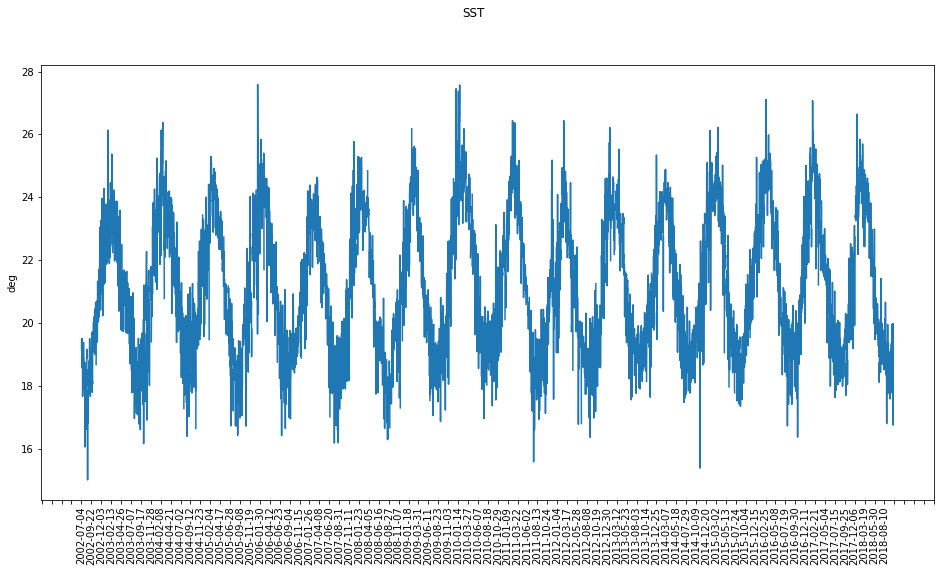

In [27]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

ax.plot(df.index,df['mean'])
ax.xaxis.set_major_locator(ticker.MultipleLocator(72))
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

**group the mean SST values by the dayofyear**

In [28]:
sst_series_g = df['mean'].groupby(df['dayofyear'])

In [144]:
dir(sst_series_g)

['MPA_NAME',
 '__bytes__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_accessors',
 '_add_numeric_operations',
 '_agg_doc',
 '_aggregate',
 '_aggregate_generic',
 '_aggregate_item_by_item',
 '_aggregate_multiple_funcs',
 '_apply_filter',
 '_apply_to_column_groupbys',
 '_apply_whitelist',
 '_assure_grouper',
 '_block_agg_axis',
 '_bool_agg',
 '_builtin_table',
 '_choose_path',
 '_concat_objects',
 '_constructor',
 '_cumcount_array',
 '_cython_agg_blocks',
 '_cython_agg_general',
 '_cython_table',
 '_cython_transform',
 '_decide_output_index',
 '_def_str',
 '_define_paths',
 '_deprecations',
 

In [254]:
list(sst_series_g)

[(1, date
  2003-01-01    22.072576
  2004-01-01    22.613347
  2005-01-01    22.840556
  2006-01-01    23.549951
  2007-01-01          NaN
  2008-01-01    21.983939
  2009-01-01    23.718886
  2010-01-01    24.737500
  2011-01-01    23.335122
  2012-01-01    20.824396
  2013-01-01    21.193333
  2014-01-01    22.626531
  2015-01-01    23.401304
  2016-01-01    22.000128
  2017-01-01    23.809465
  Name: mean, dtype: float64), (2, date
  2003-01-02    23.565201
  2004-01-02    21.315000
  2005-01-02    22.450016
  2006-01-02    24.202082
  2007-01-02    21.595972
  2008-01-02    22.263810
  2009-01-02    22.083218
  2010-01-02    25.164231
  2011-01-02          NaN
  2012-01-02    21.514919
  2013-01-02    23.910206
  2014-01-02    21.552740
  2015-01-02    24.072561
  2016-01-02    22.386442
  2017-01-02    24.525714
  Name: mean, dtype: float64), (3, date
  2003-01-03    22.628201
  2004-01-03    22.648601
  2005-01-03    24.008611
  2006-01-03    24.227197
  2007-01-03    20.911089


In [171]:
sst_series_g.describe()

count       mean       std        min        25%        50%  \
dayofyear                                                                
1           14.0  22.764788  1.081172  20.824396  22.018240  22.733543   
2           14.0  22.900151  1.294586  21.315000  21.717784  22.418229   
3           14.0  22.853009  0.971583  20.911089  22.267985  22.687930   
4           13.0  23.091498  0.808838  21.290801  22.636798  23.184999   
5           14.0  22.547564  0.988194  21.222629  21.728182  22.438554   
6           13.0  23.218728  0.803332  21.776376  22.708714  23.469751   
7           15.0  22.998963  1.127272  21.325000  22.367315  22.903462   
8           14.0  22.871240  1.379871  19.059999  22.851114  23.263811   
9           14.0  22.388009  0.897281  21.262500  21.769517  22.146885   
10          14.0  22.924411  1.336106  20.517500  22.439911  23.054868   
11          14.0  23.057083  0.760822  21.701250  22.747018  23.082738   
12          11.0  23.657479  0.983102  22.195160  23.039137  23.733943   
13          15.0  23.341880  1.518330  19.661250  22.378113  23.403257   
14          15.0  23.505394  1.744019  19.476545  23.101623  23.425557   
15          14.0  23.277754  1.250439  21.563636  22.307595  23.339495   
16          13.0  23.651784  1.725790  20.514000  23.002500  23.633291   
17          13.0  24.015181  1.100290  22.331385  23.086336  23.791364   
18          14.0  23.941569  1.171720  22.542368  23.136285  23.628330   
19          14.0  23.217526  1.184259  20.410000  22.611493  23.532166   
20          14.0  23.573586  1.207218  21.678751  22.921186  23.356777   
21          15.0  23.833535  0.947094  21.606111  23.184833  23.886821   
22          15.0  23.764350  1.452750  20.415000  23.106153  23.802346   
23          15.0  23.713928  1.200373  21.450486  22.965665  23.447500   
24          14.0  23.753927  1.405933  21.060000  22.920308  24.062991   
25          15.0  23.812760  1.399248  21.557500  23.072223  23.382640   
26          14.0  23.332708  1.243415  21.365937  22.182099  23.528190   
27          14.0  23.517965  1.429501  19.480000  22.994869  23.919284   
28          12.0  23.909754  0.946342  22.335865  23.328625  23.894233   
29          13.0  23.652034  0.959243  22.034099  22.894588  24.031719   
30          15.0  23.978235  0.787591  22.231667  23.433878  23.977171   
...          ...        ...       ...        ...        ...        ...   
336         14.0  21.389444  1.076674  19.483874  20.798241  21.414049   
337         15.0  21.700353  0.905782  20.170179  21.136608  21.687325   
338         14.0  21.952652  1.184732  19.465625  21.550096  21.985783   
339         13.0  21.699412  1.155933  19.784131  20.948802  21.996667   
340         15.0  21.888569  1.429745  18.749250  21.236251  22.051539   
341         13.0  21.744775  0.954953  19.773000  21.229924  21.699512   
342         15.0  21.932455  1.769187  17.589000  21.089276  22.360142   
343         15.0  21.786050  0.976077  20.004000  21.121404  22.229712   
344         14.0  22.191319  1.290788  19.918864  21.210952  22.247294   
345         15.0  22.210746  1.371967  19.889375  21.210857  22.553125   
346         13.0  22.377077  0.746227  21.454000  21.759086  22.107778   
347         14.0  22.863112  1.282547  20.336666  21.861208  22.722354   
348         14.0  22.240525  1.260256  19.931667  21.566483  22.574460   
349         15.0  22.642688  1.061345  20.219485  22.093963  23.004583   
350         16.0  22.583798  1.203832  20.885278  21.827376  22.301673   
351         13.0  22.693124  1.294905  20.843158  22.009860  22.593156   
352         16.0  22.666699  1.145160  20.845750  21.910909  22.516833   
353         15.0  22.241704  1.312023  19.577500  21.515223  22.185812   
354         13.0  22.287070  1.121062  19.764999  21.434999  22.696891   
355         16.0  22.759440  0.998442  20.699783  22.146221  22.789763   
356         16.0  22.544948  1.186878  20.643886  21.718907  22.457143   
357         15.

In [162]:
sst_series_g.ndim

1

**define and apply the 90 percentile function on the groupby object**

In [29]:
def nintypercentile(x):
    z = x.quantile(0.9)
    return(z)
sst_90 = sst_series_g.transform(nintypercentile)

In [35]:
sst_90_2003=sst_90.loc['2003-01-01':'2003-12-31']

In [45]:
sst_90_2003.index

Index(['2003-01-01', '2003-01-02', '2003-01-03', '2003-01-04', '2003-01-05',
       '2003-01-06', '2003-01-07', '2003-01-08', '2003-01-09', '2003-01-10',
       ...
       '2003-12-22', '2003-12-23', '2003-12-24', '2003-12-25', '2003-12-26',
       '2003-12-27', '2003-12-28', '2003-12-29', '2003-12-30', '2003-12-31'],
      dtype='object', name='date', length=365)

**plot the 90% percentile**

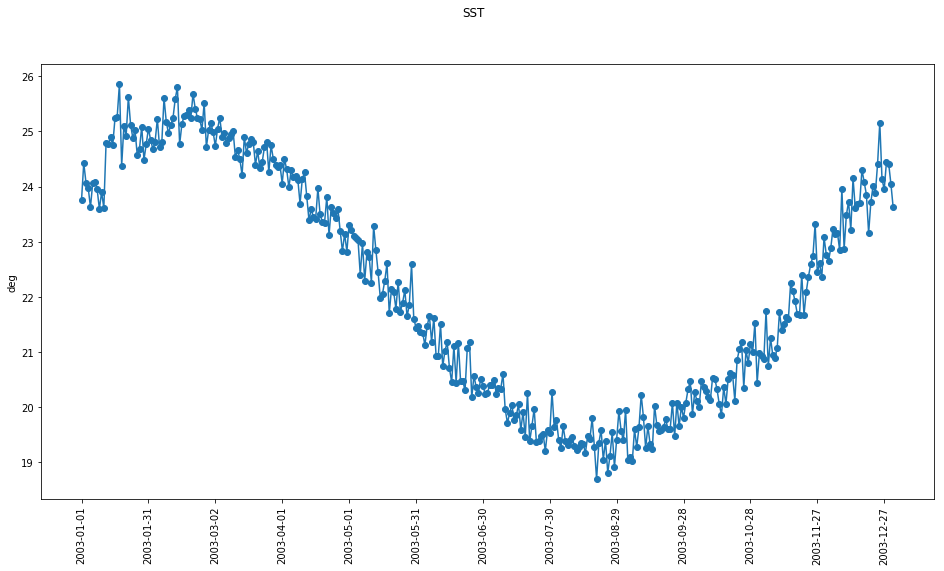

In [51]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

ax.plot(sst_90_2003.index,sst_90_2003.values,marker='o')
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()
##plt.plot(sst_90_2003.index,sst_90_2003.values)
##sst_90.loc['2003-01-01':'2003-12-31'].plot(figsize=(16,8),marker='o')

In [52]:
df['90percentile'] = sst_90

**calculate the SST difference between daily mean and the 90 perentile. 
positive value indicates a candidate to be part of a Marine Heat Wave event**

In [53]:
df['diff'] = df['mean'] - df['90percentile']

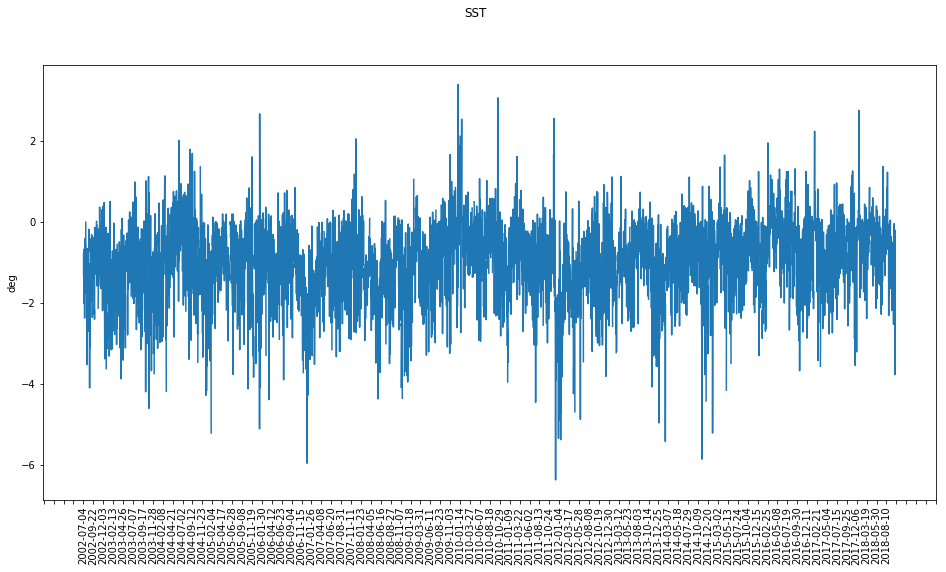

In [54]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

ax.plot(df.index,df['diff'])
ax.xaxis.set_major_locator(ticker.MultipleLocator(72))
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()
##df['diff'].plot(figsize=(16,8),marker='o')

**select a subset with positive SST difference**

In [55]:
df1=df.loc[df['diff']>0]

**select a subset with years 2009 and 2010 when the Lord Howe marine park was known to experience marine heat waves**

In [56]:
df2=df1.loc[df1['year'].isin(['2009','2010'])]

<BarContainer object of 146 artists>

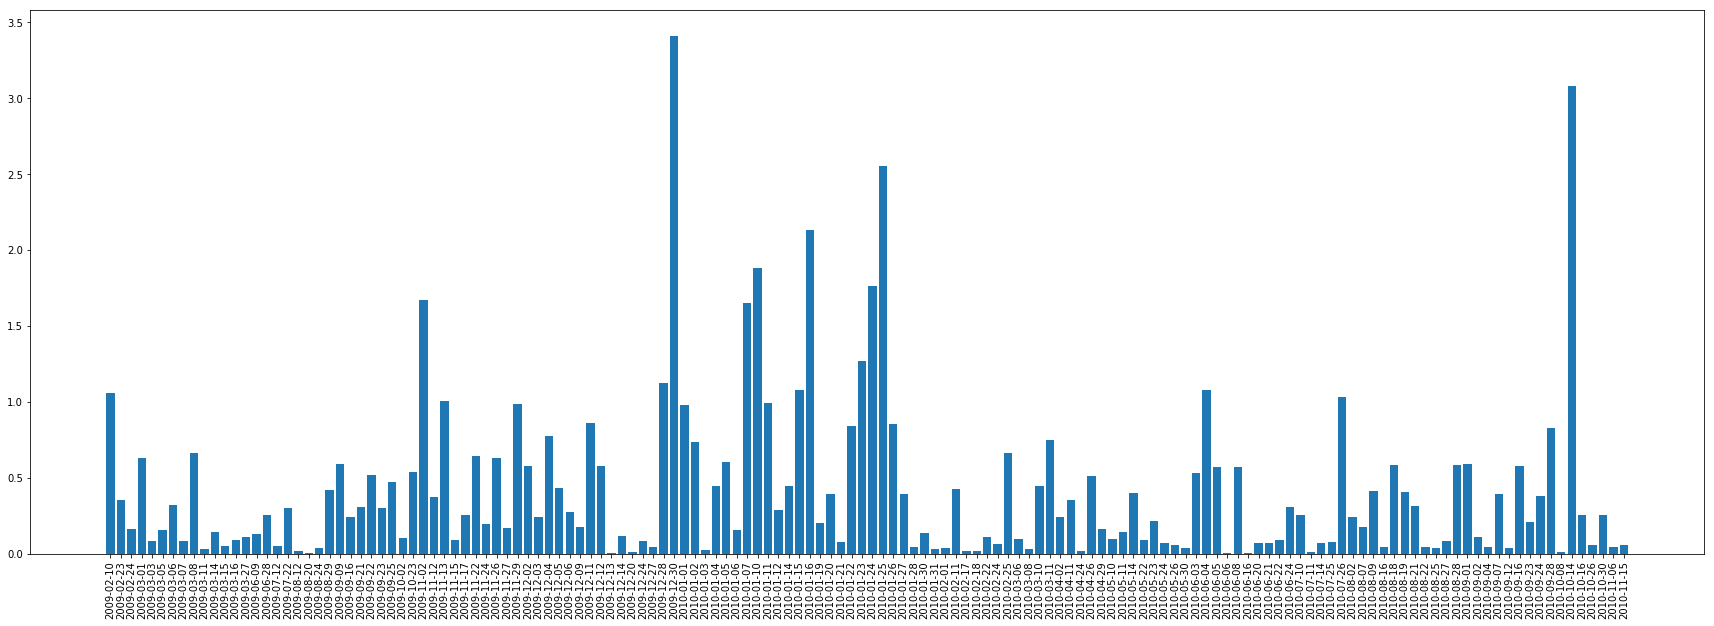

In [57]:
plt.subplots(figsize=(30,10))
plt.xticks(rotation='vertical')
plt.bar(df2.index,df2['diff'])

In [60]:
df2.shape

(146, 8)

In [61]:
from datetime import datetime
time1 = df2.index[0]
time2 = df2.index[145]
date_diff=datetime.strptime(time2,'%Y-%m-%d') - datetime.strptime(time1,'%Y-%m-%d')

In [62]:
date_diff.days

643

In [63]:
df2.shape[0]

146

**The following code blocks are used to identify individual marine heat wave events within the two year.
A marine heat wave event here is defined as a period of more than 5 days with continous positive SST different.**

In [64]:
from datetime import datetime
i = 0
dateList=[]
while i < df2.shape[0]:
    date1 = datetime.strptime(df2.index[i],'%Y-%m-%d')
    dateList.append(date1)
    i = i + 1
df2['date1']=dateList   

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [65]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, 2009-02-10 to 2010-11-15
Data columns (total 9 columns):
MPA_NAME        146 non-null object
network         146 non-null object
area            146 non-null float64
mean            146 non-null float64
dayofyear       146 non-null int64
year            146 non-null object
90percentile    146 non-null float64
diff            146 non-null float64
date1           146 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 11.4+ KB


**The date_diff column calculate the date difference between the two neighbouring records. If the date_diff is 1, the two neighbouring records are actually adjacent dates.**

In [66]:
i = 0
date_diffList=[]
while i < df2.shape[0]:
    date_diff = (df2['date1'][i]-df2.shift(periods=1)['date1'][i]).days
    date_diffList.append(date_diff)
    i = i + 1
df2['date_diff']=date_diffList   


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [67]:
df2.loc[df2['year'] == '2009'].head(10)

MPA_NAME         network           area       mean  dayofyear  \
date                                                                         
2009-02-10  Lord Howe  Temperate East  110138.572172  26.181201         41   
2009-02-23  Lord Howe  Temperate East  110138.572172  25.586536         54   
2009-02-24  Lord Howe  Temperate East  110138.572172  25.187242         55   
2009-03-01  Lord Howe  Temperate East  110138.572172  25.626250         60   
2009-03-03  Lord Howe  Temperate East  110138.572172  25.129515         62   
2009-03-05  Lord Howe  Temperate East  110138.572172  25.063645         64   
2009-03-06  Lord Howe  Temperate East  110138.572172  25.285373         65   
2009-03-07  Lord Howe  Temperate East  110138.572172  24.878955         66   
2009-03-08  Lord Howe  Temperate East  110138.572172  25.547290         67   
2009-03-11  Lord Howe  Temperate East  110138.572172  24.564828         70   

            year  90percentile      diff      date1  date_diff  
date                                                            
2009-02-10  2009     25.121892  1.059309 2009-02-10        NaN  
2009-02-23  2009     25.231290  0.355247 2009-02-23       13.0  
2009-02-24  2009     25.027068  0.160174 2009-02-24        1.0  
2009-03-01  2009     24.993461  0.632789 2009-03-01        5.0  
2009-03-03  2009     25.046701  0.082814 2009-03-03        2.0  
2009-03-05  2009     24.908247  0.155397 2009-03-05        2.0  
2009-03-06  2009     24.966352  0.319021 2009-03-06        1.0  
2009-03-07  2009     24.795622  0.083333 2009-03-07        1.0  
2009-03-08  2009     24.883657  0.663633 2009-03-08        1.0  
2009-03-11  2009     24.530908  0.033919 2009-03-11        3.0

In [68]:
df2.loc[df2['year'] == '2010']

MPA_NAME         network           area       mean  dayofyear  \
date                                                                         
2010-01-01  Lord Howe  Temperate East  110138.572172  24.737500          1   
2010-01-02  Lord Howe  Temperate East  110138.572172  25.164231          2   
2010-01-03  Lord Howe  Temperate East  110138.572172  24.099409          3   
2010-01-04  Lord Howe  Temperate East  110138.572172  24.426176          4   
2010-01-05  Lord Howe  Temperate East  110138.572172  24.232174          5   
2010-01-06  Lord Howe  Temperate East  110138.572172  24.215383          6   
2010-01-07  Lord Howe  Temperate East  110138.572172  25.740583          7   
2010-01-10  Lord Howe  Temperate East  110138.572172  25.777785         10   
2010-01-11  Lord Howe  Temperate East  110138.572172  24.607061         11   
2010-01-12  Lord Howe  Temperate East  110138.572172  25.074532         12   
2010-01-14  Lord Howe  Temperate East  110138.572172  25.347959         14   
2010-01-15  Lord Howe  Temperate East  110138.572172  25.834849         15   
2010-01-16  Lord Howe  Temperate East  110138.572172  27.367258         16   
2010-01-19  Lord Howe  Temperate East  110138.572172  24.581199         19   
2010-01-20  Lord Howe  Temperate East  110138.572172  25.494456         20   
2010-01-21  Lord Howe  Temperate East  110138.572172  24.999066         21   
2010-01-22  Lord Howe  Temperate East  110138.572172  26.464839         22   
2010-01-23  Lord Howe  Temperate East  110138.572172  26.396396         23   
2010-01-24  Lord Howe  Temperate East  110138.572172  26.646666         24   
2010-01-25  Lord Howe  Temperate East  110138.572172  27.571731         25   
2010-01-26  Lord Howe  Temperate East  110138.572172  25.422281         26   
2010-01-27  Lord Howe  Temperate East  110138.572172  25.085625         27   
2010-01-28  Lord Howe  Temperate East  110138.572172  25.132895         28   
2010-01-30  Lord Howe  Temperate East  110138.572172  24.902354         30   
2010-01-31  Lord Howe  Temperate East  110138.572172  25.083000         31   
2010-02-01  Lord Howe  Temperate East  110138.572172  24.879093         32   
2010-02-11  Lord Howe  Temperate East  110138.572172  25.663255         42   
2010-02-17  Lord Howe  Temperate East  110138.572172  25.310744         48   
2010-02-18  Lord Howe  Temperate East  110138.572172  25.415082         49   
2010-02-22  Lord Howe  Temperate East  110138.572172  25.352280         53   
2010-02-24  Lord Howe  Temperate East  110138.572172  25.094038         55   
2010-02-25  Lord Howe  Temperate East  110138.572172  26.183333         56   
2010-03-06  Lord Howe  Temperate East  110138.572172  25.062164         65   
2010-03-08  Lord Howe  Temperate East  110138.572172  24.913492         67   
2010-03-10  Lord Howe  Temperate East  110138.572172  25.449228         69   
2010-03-11  Lord Howe  Temperate East  110138.572172  25.279885         70   
2010-04-02  Lord Howe  Temperate East  110138.572172  24.739596         92   
2010-04-11  Lord Howe  Temperate East  110138.572172  24.613734        101   
2010-04-24  Lord Howe  Temperate East  110138.572172  23.530414        114   
2010-04-26  Lord Howe  Temperate East  110138.572172  24.098939        116   
2010-04-29  Lord Howe  Temperate East  110138.572172  23.306404        119   
2010-05-10  Lord Howe  Temperate East  110138.572172  22.822095        130   
2010-05-11  Lord Howe  Temperate East  110138.572172  22.408095        131   
2010-05-14  Lord Howe  Temperate East  110138.572172  22.853333        134   
2010-05-22  Lord Howe  Temperate East  110138.572172  21.876047        142   
2010-05-23  Lord Howe  Temperate East  110138.572172  22.490000        143   
2010-05-24  Lord Howe  Temperate East  110138.572172  21.800409        144   
2010-05-26  Lord Howe  Temperate East  110138.572172  22.182154        146   
2010-05-30  Lord Howe  Temperate East  110138.572172  21.641418        150   
2010-06-03  Lord Howe  Temperate Ea

**The code block forms children lists with a parent list. Each children list contains either one single date or a group of adjacent dates in the dataframe.**

In [69]:
allList = []
i = 0
while i < df2.shape[0]-1:
    tempList = []
    date = df2.index[i]
    tempList.append(date)
    date_diff = df2['date_diff'][i+1]
    if date_diff > 1:
        i = i + 1
    else:
        while i < df2.shape[0]:
            if df2['date_diff'][i+1] > 1:
                i = i + 1
                break;
            else:                
                date = df2.index[i+1]
                tempList.append(date)
                i = i + 1
    allList.append(tempList)

In [70]:
allList

[['2009-02-10'],
 ['2009-02-23', '2009-02-24'],
 ['2009-03-01'],
 ['2009-03-03'],
 ['2009-03-05', '2009-03-06', '2009-03-07', '2009-03-08'],
 ['2009-03-11'],
 ['2009-03-14', '2009-03-15', '2009-03-16'],
 ['2009-03-27'],
 ['2009-06-09'],
 ['2009-06-28'],
 ['2009-07-12'],
 ['2009-07-22'],
 ['2009-08-12'],
 ['2009-08-20'],
 ['2009-08-24'],
 ['2009-08-29'],
 ['2009-09-09'],
 ['2009-09-16'],
 ['2009-09-21', '2009-09-22', '2009-09-23'],
 ['2009-09-25'],
 ['2009-10-02'],
 ['2009-10-23'],
 ['2009-11-02'],
 ['2009-11-12', '2009-11-13'],
 ['2009-11-15'],
 ['2009-11-17'],
 ['2009-11-22'],
 ['2009-11-24'],
 ['2009-11-26', '2009-11-27'],
 ['2009-11-29'],
 ['2009-12-02', '2009-12-03', '2009-12-04', '2009-12-05', '2009-12-06'],
 ['2009-12-09'],
 ['2009-12-11', '2009-12-12', '2009-12-13', '2009-12-14'],
 ['2009-12-20'],
 ['2009-12-24'],
 ['2009-12-27', '2009-12-28'],
 ['2009-12-30'],
 ['2010-01-01',
  '2010-01-02',
  '2010-01-03',
  '2010-01-04',
  '2010-01-05',
  '2010-01-06',
  '2010-01-07'],
 ['201

In [71]:
for tempList in allList:
    
    print(len(tempList))
    if len(tempList) > 4:
        print(tempList)

1
2
1
1
4
1
3
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
2
1
1
1
1
2
1
5
['2009-12-02', '2009-12-03', '2009-12-04', '2009-12-05', '2009-12-06']
1
4
1
1
2
1
7
['2010-01-01', '2010-01-02', '2010-01-03', '2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07']
3
3
10
['2010-01-19', '2010-01-20', '2010-01-21', '2010-01-22', '2010-01-23', '2010-01-24', '2010-01-25', '2010-01-26', '2010-01-27', '2010-01-28']
3
1
2
1
2
1
1
2
1
1
1
1
1
2
1
3
1
1
4
1
1
3
1
2
1
2
1
1
1
1
2
2
1
2
2
1
1
1
1
2
1
1
1
1
1
1
1


**Apply a different definition of a marine heat wave event. In this case, a marine heat wave event  is defined as a period of more than 5 days with positive SST different, even with one-day breaks in between (e.g., '2009-11-22', '2009-11-24', '2009-11-26', '2009-11-27', '2009-11-29').**

In [72]:
allList1 = []
i = 0
while i < df2.shape[0]-1:
    tempList = []
    date = df2.index[i]
    tempList.append(date)
    date_diff = df2['date_diff'][i+1]
    if date_diff > 2:
        i = i + 1
    else:
        while i < df2.shape[0]:
            if df2['date_diff'][i+1] > 2:
                i = i + 1
                break;
            else:                
                date = df2.index[i+1]
                tempList.append(date)
                i = i + 1
    allList1.append(tempList)

In [386]:
allList1

[['2009-02-10'],
 ['2009-02-23', '2009-02-24'],
 ['2009-03-01',
  '2009-03-03',
  '2009-03-05',
  '2009-03-06',
  '2009-03-07',
  '2009-03-08'],
 ['2009-03-11'],
 ['2009-03-14', '2009-03-15', '2009-03-16'],
 ['2009-03-27'],
 ['2009-06-09'],
 ['2009-06-28'],
 ['2009-07-12'],
 ['2009-07-22'],
 ['2009-08-12'],
 ['2009-08-20'],
 ['2009-08-24'],
 ['2009-08-29'],
 ['2009-09-09'],
 ['2009-09-13'],
 ['2009-09-16'],
 ['2009-09-21', '2009-09-22', '2009-09-23', '2009-09-25'],
 ['2009-10-02'],
 ['2009-10-23'],
 ['2009-11-02'],
 ['2009-11-07'],
 ['2009-11-12', '2009-11-13', '2009-11-15', '2009-11-17'],
 ['2009-11-22', '2009-11-24', '2009-11-26', '2009-11-27', '2009-11-29'],
 ['2009-12-02', '2009-12-03', '2009-12-04', '2009-12-05', '2009-12-06'],
 ['2009-12-09', '2009-12-11', '2009-12-12', '2009-12-13', '2009-12-14'],
 ['2009-12-20'],
 ['2009-12-24'],
 ['2009-12-27',
  '2009-12-28',
  '2009-12-30',
  '2010-01-01',
  '2010-01-02',
  '2010-01-03',
  '2010-01-04',
  '2010-01-05',
  '2010-01-06',
  '201

In [73]:
for tempList in allList1:
    
    print(len(tempList))
    if len(tempList) > 4:
        print(tempList)

1
2
6
['2009-03-01', '2009-03-03', '2009-03-05', '2009-03-06', '2009-03-07', '2009-03-08']
1
3
1
1
1
1
1
1
1
1
1
1
1
4
1
1
1
4
5
['2009-11-22', '2009-11-24', '2009-11-26', '2009-11-27', '2009-11-29']
5
['2009-12-02', '2009-12-03', '2009-12-04', '2009-12-05', '2009-12-06']
5
['2009-12-09', '2009-12-11', '2009-12-12', '2009-12-13', '2009-12-14']
1
1
10
['2009-12-27', '2009-12-28', '2009-12-30', '2010-01-01', '2010-01-02', '2010-01-03', '2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07']
6
['2010-01-10', '2010-01-11', '2010-01-12', '2010-01-14', '2010-01-15', '2010-01-16']
13
['2010-01-19', '2010-01-20', '2010-01-21', '2010-01-22', '2010-01-23', '2010-01-24', '2010-01-25', '2010-01-26', '2010-01-27', '2010-01-28', '2010-01-30', '2010-01-31', '2010-02-01']
1
2
3
4
1
1
2
1
2
1
4
1
5
['2010-06-03', '2010-06-04', '2010-06-05', '2010-06-06', '2010-06-08']
1
4
2
1
2
1
2
5
['2010-08-16', '2010-08-18', '2010-08-19', '2010-08-21', '2010-08-22']
3
3
1
1
1
2
1
1
2
1
1
1


**Plot the marine heat wave events identified between November 2009 and Feb 2010**

In [74]:
df3 = df.loc['2009-11-15':'2010-02-07']

In [75]:
df3

MPA_NAME         network           area       mean  dayofyear  \
date                                                                         
2009-11-15  Lord Howe  Temperate East  110138.572172  22.334107        319   
2009-11-16  Lord Howe  Temperate East  110138.572172  21.525778        320   
2009-11-17  Lord Howe  Temperate East  110138.572172  22.177651        321   
2009-11-18  Lord Howe  Temperate East  110138.572172  21.693317        322   
2009-11-19  Lord Howe  Temperate East  110138.572172  21.546360        323   
2009-11-20  Lord Howe  Temperate East  110138.572172  21.536619        324   
2009-11-21  Lord Howe  Temperate East  110138.572172  19.906538        325   
2009-11-22  Lord Howe  Temperate East  110138.572172  22.731414        326   
2009-11-23  Lord Howe  Temperate East  110138.572172  22.314504        327   
2009-11-24  Lord Howe  Temperate East  110138.572172  22.788416        328   
2009-11-25  Lord Howe  Temperate East  110138.572172  22.729406        329   
2009-11-26  Lord Howe  Temperate East  110138.572172  23.953486        330   
2009-11-27  Lord Howe  Temperate East  110138.572172  22.616387        331   
2009-11-28  Lord Howe  Temperate East  110138.572172        NaN        332   
2009-11-29  Lord Howe  Temperate East  110138.572172  23.349327        333   
2009-11-30  Lord Howe  Temperate East  110138.572172        NaN        334   
2009-12-01  Lord Howe  Temperate East  110138.572172  21.736429        335   
2009-12-02  Lord Howe  Temperate East  110138.572172  23.227459        336   
2009-12-03  Lord Howe  Temperate East  110138.572172  23.123535        337   
2009-12-04  Lord Howe  Temperate East  110138.572172  24.013378        338   
2009-12-05  Lord Howe  Temperate East  110138.572172  23.570254        339   
2009-12-06  Lord Howe  Temperate East  110138.572172  23.443021        340   
2009-12-07  Lord Howe  Temperate East  110138.572172  22.189244        341   
2009-12-08  Lord Howe  Temperate East  110138.572172  23.857439        342   
2009-12-09  Lord Howe  Temperate East  110138.572172  23.044978        343   
2009-12-10  Lord Howe  Temperate East  110138.572172        NaN        344   
2009-12-11  Lord Howe  Temperate East  110138.572172  24.592143        345   
2009-12-12  Lord Howe  Temperate East  110138.572172  23.789684        346   
2009-12-13  Lord Howe  Temperate East  110138.572172  24.163678        347   
2009-12-14  Lord Howe  Temperate East  110138.572172  23.734032        348   
2009-12-15  Lord Howe  Temperate East  110138.572172  23.480563        349   
2009-12-16  Lord Howe  Temperate East  110138.572172  23.703832        350   
2009-12-17  Lord Howe  Temperate East  110138.572172        NaN        351   
2009-12-18  Lord Howe  Temperate East  110138.572172  23.433900        352   
2009-12-19  Lord Howe  Temperate East  110138.572172  22.827742        353   
2009-12-20  Lord Howe  Temperate East  110138.572172  23.169331        354   
2009-12-21  Lord Howe  Temperate East  110138.572172  23.365400        355   
2009-12-22  Lord Howe  Temperate East  110138.572172  21.413571        356   
2009-12-23  Lord Howe  Temperate East  110138.572172  22.784011        357   
2009-12-24  Lord Howe  Temperate East  110138.572172  24.487500        358   
2009-12-25  Lord Howe  Temperate East  110138.572172  23.078871        359   
2009-12-26  Lord Howe  Temperate East  110138.572172  22.471500        360   
2009-12-27  Lord Howe  Temperate East  110138.572172  24.002880        361   
2009-12-28  Lord Howe  Temperate East  110138.572172  25.578214        362   
2009-12-29  Lord Howe  Temperate East  110138.572172  24.204863        363   
2009-12-30  Lord Howe  Temperate East  110138.572172  27.453788        364   
2009-12-31  Lord Howe  Temperate East  110138.572172  22.022333        365   
2010-01-01  Lord Howe  Temperate East  110138.572172  24.737500          1   
2010-01-02  Lord Howe  Temperate East  110138.572172  25.164231          2   
2010-01-03  Lord Howe  Temperate Ea

<BarContainer object of 85 artists>

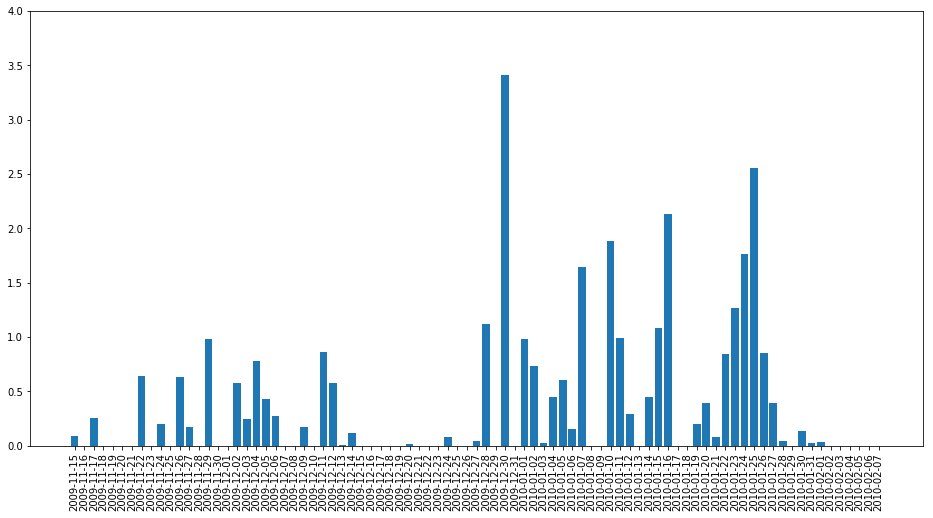

In [144]:
plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')
plt.ylim(0,4)
plt.bar(df3.index,df3['diff'])

**load SST data for the period that contains the identified MHW events**

In [77]:
df2.to_csv('/home/547/zxh547/dea-notebooks/MODIS/temp/df2.csv',sep=',')

In [79]:
data_0910 = dc.load(product='modis_oc_1d', time=('2009-11-15','2010-02-07'), lat=(-17,-46), lon=(150,165), resolution=(-0.1, 0.1), measurements=(['sst']))

In [81]:
data_0910 = mask_invalid_data(data_0910)

In [82]:
data_0910

<xarray.Dataset>
Dimensions:    (latitude: 290, longitude: 150, time: 85)
Coordinates:
  * time       (time) datetime64[ns] 2009-11-15T11:59:59.999999 ... 2010-02-07T11:59:59.999999
  * latitude   (latitude) float64 -17.05 -17.15 -17.25 ... -45.75 -45.85 -45.95
  * longitude  (longitude) float64 150.1 150.2 150.2 150.4 ... 164.8 164.9 165.0
Data variables:
    sst        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    crs:      EPSG:4326

**generate SST composites for the normal periods and the MHW events**

In [90]:
mhw1_sst=data_0910.sel(time=slice('2009-11-22','2009-11-29'))

mhw1_sst1 = mhw1_sst.mean(dim='time')

In [106]:
mhw2_sst=data_0910.sel(time=slice('2009-12-02','2009-12-06'))

mhw2_sst1 = mhw2_sst.mean(dim='time')

In [107]:
mhw3_sst=data_0910.sel(time=slice('2009-12-09','2009-12-14'))

mhw3_sst1 = mhw3_sst.mean(dim='time')

In [108]:
mhw4_sst=data_0910.sel(time=slice('2009-12-27','2010-01-07'))

mhw4_sst1 = mhw4_sst.mean(dim='time')

In [109]:
mhw5_sst=data_0910.sel(time=slice('2010-01-10','2010-01-16'))

mhw5_sst1 = mhw5_sst.mean(dim='time')

In [110]:
mhw6_sst=data_0910.sel(time=slice('2010-01-19','2010-02-01'))

mhw6_sst1 = mhw6_sst.mean(dim='time')

In [111]:
nor1_sst=data_0910.sel(time=slice('2009-11-15','2009-11-21'))

nor1_sst1 = nor1_sst.mean(dim='time')

In [112]:
nor2_sst=data_0910.sel(time=slice('2009-12-15','2009-12-26'))

nor2_sst1 = nor2_sst.mean(dim='time')

In [113]:
nor3_sst=data_0910.sel(time=slice('2010-02-02','2010-02-07'))

nor3_sst1 = nor3_sst.mean(dim='time')

**Plot these events (normal and MHW)**

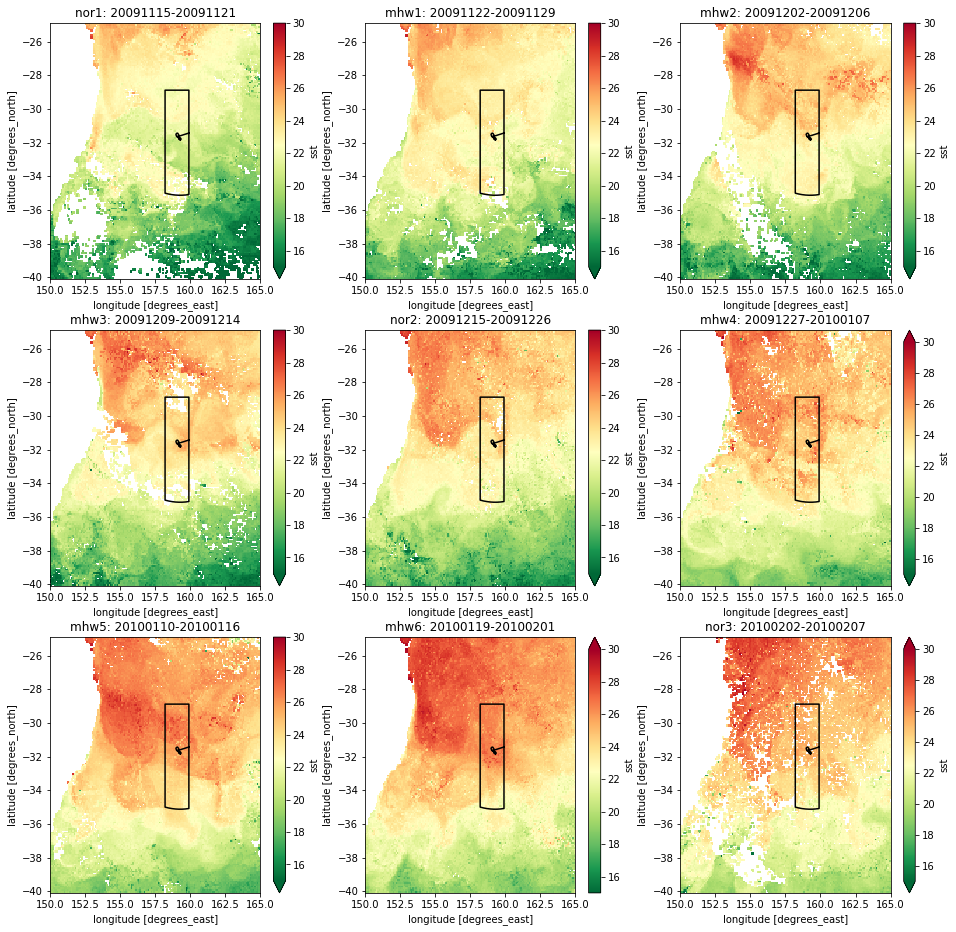

In [156]:
import shapefile as shpf

LH = shpf.Reader(poly_path)
plt.figure(figsize=(16,16))

plt.subplot(3,3,1)
nor1_sst1.sel(latitude=slice(-24.95,-40.05)).sst.plot(cmap='RdYlGn_r',vmin=15,vmax=30)
plt.title('nor1: 20091115-20091121')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(3,3,2)
mhw1_sst1.sel(latitude=slice(-24.95,-40.05)).sst.plot(cmap='RdYlGn_r',vmin=15,vmax=30)
plt.title('mhw1: 20091122-20091129')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(3,3,3)
mhw2_sst1.sel(latitude=slice(-24.95,-40.05)).sst.plot(cmap='RdYlGn_r',vmin=15,vmax=30)
plt.title('mhw2: 20091202-20091206')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(3,3,4)
mhw3_sst1.sel(latitude=slice(-24.95,-40.05)).sst.plot(cmap='RdYlGn_r',vmin=15,vmax=30)
plt.title('mhw3: 20091209-20091214')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]  
    plt.plot(x, y, 'k')
    
plt.subplot(3,3,5)
nor2_sst1.sel(latitude=slice(-24.95,-40.05)).sst.plot(cmap='RdYlGn_r',vmin=15,vmax=30)
plt.title('nor2: 20091215-20091226')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(3,3,6)
mhw4_sst1.sel(latitude=slice(-24.95,-40.05)).sst.plot(cmap='RdYlGn_r',vmin=15,vmax=30)
plt.title('mhw4: 20091227-20100107')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(3,3,7)
mhw5_sst1.sel(latitude=slice(-24.95,-40.05)).sst.plot(cmap='RdYlGn_r',vmin=15,vmax=30)
plt.title('mhw5: 20100110-20100116')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(3,3,8)
mhw6_sst1.sel(latitude=slice(-24.95,-40.05)).sst.plot(cmap='RdYlGn_r',vmin=15,vmax=30)
plt.title('mhw6: 20100119-20100201')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(3,3,9)
nor3_sst1.sel(latitude=slice(-24.95,-40.05)).sst.plot(cmap='RdYlGn_r',vmin=15,vmax=30)
plt.title('nor3: 20100202-20100207')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
plt.show()

**construct a dataframe for the attributes of the identified MHW events (dates, duration and intensity)**

In [169]:
MHWList=[]
durationList=[]
intensityList=[]
mhwDF = pd.DataFrame()
for tempList in allList1:
    
   if len(tempList) > 4:
        MHWList.append(tempList)
        durationList.append(len(tempList))
        intensityList.append(df2.loc[df2['date1'].isin(tempList)]['diff'].mean())

mhwDF['MHWDates'] = MHWList
mhwDF['Duration'] = durationList
mhwDF['Intensity'] = intensityList

In [170]:
mhwDF

MHWDates  Duration  Intensity
0  [2009-03-01, 2009-03-03, 2009-03-05, 2009-03-0...         6   0.322831
1  [2009-11-22, 2009-11-24, 2009-11-26, 2009-11-2...         5   0.526748
2  [2009-12-02, 2009-12-03, 2009-12-04, 2009-12-0...         5   0.461092
3  [2009-12-09, 2009-12-11, 2009-12-12, 2009-12-1...         5   0.349026
4  [2009-12-27, 2009-12-28, 2009-12-30, 2010-01-0...        10   0.918658
5  [2010-01-10, 2010-01-11, 2010-01-12, 2010-01-1...         6   1.136724
6  [2010-01-19, 2010-01-20, 2010-01-21, 2010-01-2...        13   0.660958
7  [2010-06-03, 2010-06-04, 2010-06-05, 2010-06-0...         5   0.552312
8  [2010-08-16, 2010-08-18, 2010-08-19, 2010-08-2...         5   0.279266

In [173]:
pd.set_option('display.max_colwidth', -1)
mhwDF

MHWDates  \
0  [2009-03-01, 2009-03-03, 2009-03-05, 2009-03-06, 2009-03-07, 2009-03-08]                                                                                       
1  [2009-11-22, 2009-11-24, 2009-11-26, 2009-11-27, 2009-11-29]                                                                                                   
2  [2009-12-02, 2009-12-03, 2009-12-04, 2009-12-05, 2009-12-06]                                                                                                   
3  [2009-12-09, 2009-12-11, 2009-12-12, 2009-12-13, 2009-12-14]                                                                                                   
4  [2009-12-27, 2009-12-28, 2009-12-30, 2010-01-01, 2010-01-02, 2010-01-03, 2010-01-04, 2010-01-05, 2010-01-06, 2010-01-07]                                       
5  [2010-01-10, 2010-01-11, 2010-01-12, 2010-01-14, 2010-01-15, 2010-01-16]                                                                                       
6  [2010-01-19, 2010-01-20, 2010-01-21, 2010-01-22, 2010-01-23, 2010-01-24, 2010-01-25, 2010-01-26, 2010-01-27, 2010-01-28, 2010-01-30, 2010-01-31, 2010-02-01]   
7  [2010-06-03, 2010-06-04, 2010-06-05, 2010-06-06, 2010-06-08]                                                                                                   
8  [2010-08-16, 2010-08-18, 2010-08-19, 2010-08-21, 2010-08-22]                                                                                                   

   Duration  Intensity  
0  6         0.322831   
1  5         0.526748   
2  5         0.461092   
3  5         0.349026   
4  10        0.918658   
5  6         1.136724   
6  13        0.660958   
7  5         0.552312   
8  5         0.279266